In [1]:
import glob
import os
import cv2
import glob
import re
import json
import h5py

import matplotlib as mpl
import tifffile as tf
import pandas as pd
import pylab as pl
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from scipy import misc,interpolate,stats,signal


In [2]:
%matplotlib notebook

In [182]:
# -----------------------------------------------------------------------------
# Commonly used, generic methods:
# -----------------------------------------------------------------------------
def get_pixel_size():
    # Use measured pixel size from PSF (20191005, most recent)
    # ------------------------------------------------------------------
    xaxis_conversion = 2.3 #1  # size of x-axis pixel, goes with A-P axis
    yaxis_conversion = 1.9 #89  # size of y-axis pixels, goes with M-L axis
    return (xaxis_conversion, yaxis_conversion)

def label_figure(fig, data_identifier):
    fig.text(0, 1,data_identifier, ha='left', va='top', fontsize=8)

def convert_range(oldval, newmin=None, newmax=None, oldmax=None, oldmin=None):
    oldrange = (oldmax - oldmin)
    newrange = (newmax - newmin)
    newval = (((oldval - oldmin) * newrange) / oldrange) + newmin
    return newval

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]


def get_screen_dims():
    screen_x = 59.7782*2 #119.5564
    screen_y =  33.6615*2. #67.323
    resolution = [1920, 1080] #[1024, 768]
    deg_per_pixel_x = screen_x / float(resolution[0])
    deg_per_pixel_y = screen_y / float(resolution[1])
    deg_per_pixel = np.mean([deg_per_pixel_x, deg_per_pixel_y])
    screen = {'azimuth_deg': screen_x,
              'altitude_deg': screen_y,
              'azimuth_cm': 103.0,
              'altitude_cm': 58.0,
              'resolution': resolution,
              'deg_per_pixel': (deg_per_pixel_x, deg_per_pixel_y)}

    return screen

In [4]:
# from scipy import misc,interpolate,stats,signal
def smooth_array(inputArray, fwhm, phaseArray=False):
    szList=np.array([None,None,None,11,None,21,None,27,None,31,None,37,None,43,None,49,None,53,None,59,None,55,None,69,None,79,None,89,None,99])
    sigmaList=np.array([None,None,None,.9,None,1.7,None,2.6,None,3.4,None,4.3,None,5.1,None,6.4,None,6.8,None,7.6,None,8.5,None,9.4,None,10.3,None,11.2,None,12])
    sigma=sigmaList[fwhm]
    sz=szList[fwhm]
    #print(sigma, sz)
    if phaseArray:
        outputArray = smooth_phase_array(inputArray,sigma,sz)
    else:
        outputArray=cv2.GaussianBlur(inputArray, (sz,sz), sigma, sigma)
        
    return outputArray
        
def smooth_phase_array(theta,sigma,sz):
    #build 2D Gaussian Kernel
    kernelX = cv2.getGaussianKernel(sz, sigma); 
    kernelY = cv2.getGaussianKernel(sz, sigma); 
    kernelXY = kernelX * kernelY.transpose(); 
    kernelXY_norm=np.true_divide(kernelXY,np.max(kernelXY.flatten()))
    
    #get x and y components of unit-length vector
    componentX=np.cos(theta)
    componentY=np.sin(theta)
    
    #convolce
    componentX_smooth=signal.convolve2d(componentX,kernelXY_norm,mode='same',boundary='symm')
    componentY_smooth=signal.convolve2d(componentY,kernelXY_norm,mode='same',boundary='symm')

    theta_smooth=np.arctan2(componentY_smooth,componentX_smooth)
    return theta_smooth


# def process_maps(mapdata, smooth_fwhm=None, mag_thr=None, recenter=True, mask_mag=True):
#     phase_az = mapdata['phaseMap'].copy()
#     mag_az = mapdata['magRatioMap'].copy()
    
#     # phase_az[mag_az<mag_thr]=np.nan

#     if smooth_fwhm is not None:
#         phase_az =smooth_array(phase_az, smooth_fwhm, phaseArray=True)
#         mag_az = smooth_array(mag_az, smooth_fwhm)

#     if recenter:
#         phaseC_az = shift_map(phase_az)
#         phasemin = 0
#         phasemax = 2*np.pi
#     else:
#         phaseC_az = np.copy(phase_az)
#         phasemin = -np.pi
#         phasemax = np.pi

#     phaseC_az[mag_az<mag_thr]=np.nan
    
#     magC_az = mag_az.copy()
#     if mask_mag:
#         magC_az[mag_az<mag_thr]=np.nan
    
#     return phaseC_az, magC_az, phasemin, phasemax

def shift_map(phase_az):
    phaseC_az=np.copy(phase_az)
    if phase_az[~np.isnan(phase_az)].min() < 0 and phase_az[~np.isnan(phase_az)].max() > 0:
        phaseC_az[phase_az<0]=-phase_az[phase_az<0]
        phaseC_az[phase_az>0]=(2*np.pi)-phase_az[phase_az>0]
    else:
        print("Already non-negative (min/max: %.2f, %.2f)" % (phase_az.min(), phase_az.max()))
    return phaseC_az


In [5]:
def convert_to_absolute(cond_data, smooth_fwhm=7, smooth=True, power_metric='mag'):
    '''combine absolute, or shift single-cond map so that
    
    if AZI, 0=left, 2*np.pi=right 
    if ALT, 0=bottom 2*np.pi= top
    
    Use this to convert to linear coords, centered around 0.
    power_metric: can be 'mag' or 'magRatio' (for Map type saved in analyzed maps).
    '''
    vmin = 0
    vmax = 2*np.pi

    combined_phase_map = convert_absolute_phasemap(cond_data, smooth_fwhm=smooth_fwhm, smooth=smooth)
    combined_mag_map =  convert_absolute_magmap(cond_data, smooth_fwhm=smooth_fwhm, smooth=smooth, 
                                                power_metric=power_metric)
    return combined_phase_map, combined_mag_map #_shift



def convert_absolute_phasemap(cond_data, smooth_fwhm=7, smooth=True):
    '''combine absolute, or shift single-cond map so that
    
    if AZI, 0=left, 2*np.pi=right 
    if ALT, 0=bottom 2*np.pi= top
    
    Use this to convert to linear coords, centered around 0.
    
    power_metric: can be 'mag' or 'magRatio' (for Map type saved in analyzed maps).
    
    '''
    vmin = 0
    vmax = 2*np.pi

    if len(cond_data.keys()) > 1:
        print("True absolute")
        c1 = 'left' if 'left' in cond_data.keys() else 'top'
        c2 = 'right' if c1=='left' else 'bottom'
    
        # Phase maps
        if smooth:
            m1 = shift_map(smooth_array(cond_data[c1]['phaseMap'], smooth_fwhm, phaseArray=True))
            m2 = shift_map(smooth_array(cond_data[c2]['phaseMap'], smooth_fwhm, phaseArray=True))
        else:
            m1 = shift_map(cond_data[c1]['phaseMap'])
            m2 = shift_map(cond_data[c2]['phaseMap'])
            
        combined_phase_map = spstats.circmean(np.dstack([m1, m2]), axis=-1, low=vmin, high=vmax) 

    else:
        print("Single cond")
        if 'right' in cond_data.keys() and 'top' not in cond_data.keys():
            m1 = cond_data['right']['phaseMap'].copy()
            m2 = cond_data['right']['phaseMap'].copy()*-1
            
        elif 'top' in cond_data.keys() and 'right' not in cond_data.keys():
            m1 = cond_data['top']['phaseMap'].copy()
            m2 = cond_data['top']['phaseMap'].copy()*-1
            
        # Phase maps
        combined_phase_map = (m2-m1)/2.
        
        if smooth:
            combined_phase_map = smooth_array(combined_phase_map, smooth_fwhm, phaseArray=True)
        
        # Shift maps
        combined_phase_map = shift_map(combined_phase_map) # values should go from 0 to 2*pi        
    
    return combined_phase_map #_shift


def convert_absolute_magmap(cond_data, smooth_fwhm=7, smooth=True, power_metric='mag'):
    '''combine absolute, or shift single-cond map so that
    
    if AZI, 0=left, 2*np.pi=right 
    if ALT, 0=bottom 2*np.pi= top
    
    Use this to convert to linear coords, centered around 0.
    
    power_metric: can be 'mag' or 'magRatio' (for Map type saved in analyzed maps).
    
    '''
    if len(cond_data.keys()) > 1:
        print("True absolute")
        c1 = 'left' if 'left' in cond_data.keys() else 'top'
        c2 = 'right' if c1=='left' else 'bottom'
        
        # Mag maps
        if smooth:
            p1 = smooth_array(cond_data[c1]['%sMap' % power_metric], smooth_fwhm, phaseArray=False)
            p2 = smooth_array(cond_data[c2]['%sMap' % power_metric], smooth_fwhm, phaseArray=False)
        else:
            p1 = cond_data[c1]['%sMap' % power_metric]
            p2 = cond_data[c2]['%sMap' % power_metric]
            
        combined_mag_map = np.mean(np.dstack([p1, p2]), axis=-1)

    else:
        print("Single cond")
        if 'right' in cond_data.keys() and 'top' not in cond_data.keys():
            p1 = cond_data['right']['%sMap' % power_metric].copy()
            
        elif 'top' in cond_data.keys() and 'right' not in cond_data.keys():
            p1 = cond_data['top']['%sMap' % power_metric].copy()
        
        # Mag maps
        combined_mag_map = p1
        
        if smooth:
            combined_mag_map = smooth_array(combined_mag_map, smooth_fwhm, phaseArray=False)
        
    return combined_mag_map #_shift


# Source data paths

In [6]:
surface_basedir = '/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant'

rootdir = '/n/coxfs01/2p-data'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

# Widefield:
analysis_basedir = '/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant'
analysis_subdirs = 'Analyses/timecourse/not_motion_corrected/excludeEdges_averageFrames_11_minusRollingMean'


# Select animalid

In [8]:
animalid ='JC084' # 'JC097' #'JC117' #'JC113' #'JC076'

# find sessions
found_sessions = np.unique([os.path.split(sesh)[-1].split('_')[0] \
                  for sesh in glob.glob(os.path.join(analysis_basedir, animalid, '2019*'))])
print('[%s]: Found %i sessions' % (animalid, len(found_sessions)))
for si, sesh in enumerate(found_sessions):
    print(si, sesh)
sesh = found_sessions[-1]
print(sesh)
surface_path = glob.glob(os.path.join(analysis_basedir, animalid, '%s*' % sesh, 'Surface', '*.png'))[0]
print(surface_path)
session = os.path.split(surface_path.split('/Surface')[0])[-1].split('_')[0]
data_id = '%s_%s' % (animalid, session)
print("DATA ID: %s" % data_id)

[JC084]: Found 1 sessions
0 20190517
20190517
/n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant/JC084/20190517_high_res/Surface/16bitSurf.png
DATA ID: JC084_20190517


In [9]:
# surface_path = glob.glob(os.path.join(surface_basedir, animalid, '%s_high*' % session, 'Surface', '*.png'))[0]
surface_hd = cv2.imread(surface_path, -1)
print(surface_hd.shape)

surface_path2 = glob.glob(os.path.join(surface_basedir, animalid, '%s' % session, 'Surface', '*.png'))[0]
surface = cv2.imread(surface_path2, -1)
print(surface.shape)

widefield_d1, widefield_d2 = surface_hd.shape
print("Surface image (%i, %i | %s)" % (widefield_d1, widefield_d2, surface_hd.dtype))

(492, 656)
(164, 218)
Surface image (492, 656 | uint16)


<IPython.core.display.Javascript object>


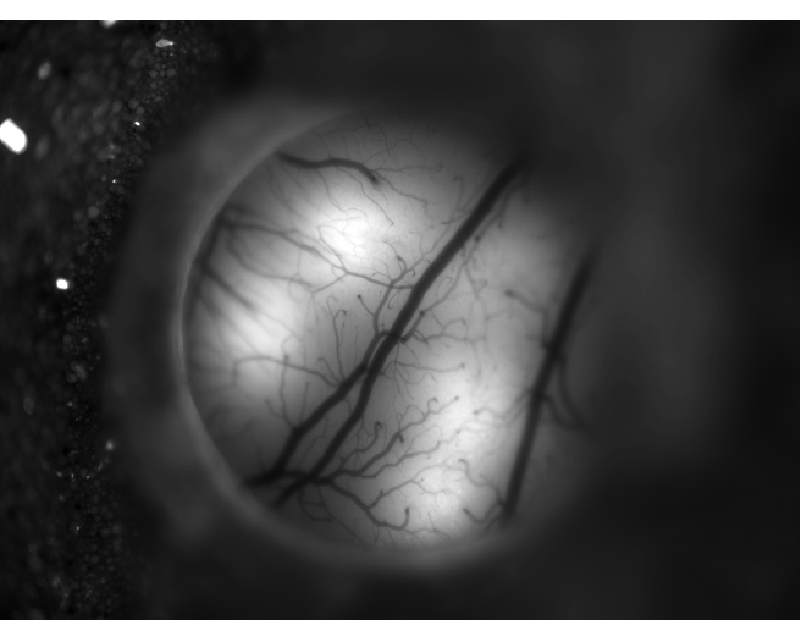

In [16]:
fig = pl.figure(figsize=(5,4), frameon=False)
ax = pl.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
im = ax.imshow(surface_hd, cmap='gray', interpolation='nearest')


# Load map arrays

In [17]:
#### Processed map data paths
# mappaths = glob.glob(os.path.join(analysis_basedir, animalid, '%s*' % session, analysis_subdirs, 'phase_decoding', 'Files', '*.npz'))
# mappaths
mappaths = glob.glob(os.path.join(analysis_basedir, animalid, '%s*' % session, 
                                  analysis_subdirs, 'phase_decoding', 'Files', '*.npz'))
for i, p in enumerate(mappaths):
    print(i, p)

condition_nums = {1: 'left',
                  2: 'right',
                  3: 'top',
                  4: 'bottom'}

condition_keys = {'azimuth': ['left', 'right'],
                  'altitude': ['top', 'bottom']}

mappath_d = {}
for mpath in mappaths:

    cond_name = re.findall(r'cond\d{1}_maps', mpath)[0]
    cond_num = int(re.findall(r'\d{1}', cond_name)[0])
    curr_cond = condition_nums[cond_num]
    
    mappath_d.update({curr_cond: mpath})
    

0 /n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant/JC084/20190517/Analyses/timecourse/not_motion_corrected/excludeEdges_averageFrames_11_minusRollingMean/phase_decoding/Files/20190517_cond2_maps.npz
1 /n/coxfs01/widefield-data/analyzed_data/Retinotopy/phase_encoding/Images_Cartesian_Constant/JC084/20190517/Analyses/timecourse/not_motion_corrected/excludeEdges_averageFrames_11_minusRollingMean/phase_decoding/Files/20190517_cond3_maps.npz


# Convert and process maps

In [18]:
mappath_d.keys()

dict_keys(['right', 'top'])

In [19]:
shift = True
smooth_fwhm = 7
smooth_first = True

vmin = 0 if shift else -np.pi
vmax = 2*np.pi if shift else np.pi

condition_keys = {'azimuth': ['left', 'right'],
                  'altitude': ['top', 'bottom']}

power_metric = 'mag'
alt_power_metric = 'magRatio' if power_metric=='mag' else 'mag'

mapdata = {}
all_mapdata = {}
for cond, bar_pos in condition_keys.items():
    
    cond_data = dict((bpos, np.load(mappath_d[bpos])) for bpos in bar_pos if bpos in mappath_d.keys())
    phasemap_, magmap_ = convert_to_absolute(cond_data, smooth_fwhm=smooth_fwhm, smooth=smooth_first,
                                            power_metric=power_metric)
    magmap_2 = convert_absolute_magmap(cond_data, smooth_fwhm=smooth_fwhm, smooth=smooth_first,
                                        power_metric=alt_power_metric)
    # Rescale if needed
    map_d1, map_d2 = phasemap_.shape
    resize_maps_d1 = widefield_d1/float(map_d1)
    resize_maps_d2 = widefield_d2/float(map_d2)

    if map_d1 != widefield_d1 or map_d2 != widefield_d2:
        phasemap_ = cv2.resize(phasemap_, (widefield_d2, widefield_d1), fx=resize_maps_d1, fy=resize_maps_d2)
        magmap_ = cv2.resize(magmap_, (widefield_d2, widefield_d1), fx=resize_maps_d1, fy=resize_maps_d2)
        magmap_2 = cv2.resize(magmap_2, (widefield_d2, widefield_d1), fx=resize_maps_d1, fy=resize_maps_d2)
    mapdata[cond] = {'phase': phasemap_, 
                     power_metric: magmap_,
                     alt_power_metric: magmap_2}    

    all_mapdata.update(cond_data)


Single cond
Single cond
Single cond
Single cond
Single cond
Single cond


In [20]:
cond_data

{'top': <numpy.lib.npyio.NpzFile at 0x2b037b13cd30>}

In [21]:
# Widefield screenscreen_w, screen_h = (117, 67)
screen_w, screen_h = (117, 67)
screen_w_deg = screen_w/2.
screen_h_deg = screen_h/2.

print(screen_w_deg, screen_h_deg)

lmin_azi, lmax_azi = (-screen_w_deg, screen_w_deg)
lmin_alt, lmax_alt = (-screen_w_deg, screen_w_deg) #(-33.66, 33.66)
screen_h_min, screen_h_max = (-screen_h_deg, screen_h_deg)

print("Old min/max: %.2f, %.2f" % (vmin, vmax))
print("[AZI] New min/max: %.2f, %.2f" % (lmin_azi, lmax_azi))
print("[ALT] New min/max: %.2f, %.2f" % (lmin_alt, lmax_alt))


58.5 33.5
Old min/max: 0.00, 6.28
[AZI] New min/max: -58.50, 58.50
[ALT] New min/max: -58.50, 58.50


In [22]:
#### Linear range
azi_map = mapdata['azimuth']['phase'].copy() #mapdata['azimuth'].copy()
alt_map = mapdata['altitude']['phase'].copy()
azi_pwr = mapdata['azimuth']['%s' % power_metric]/mapdata['azimuth']['%s' % power_metric].max()
alt_pwr = mapdata['altitude']['%s' % power_metric]/mapdata['altitude']['%s' % power_metric].max()


azi_lin = convert_range(azi_map, newmin=lmin_azi, newmax=lmax_azi, oldmin=vmin, oldmax=vmax)
alt_lin = convert_range(alt_map, newmin=lmin_alt, newmax=lmax_alt, oldmin=vmin, oldmax=vmax)

print(azi_lin.min(), azi_lin.max())

-58.27614090184562 58.3328209863941


In [23]:
mag_thr=0.01
azi_mag = mapdata['azimuth']['magRatio'].copy()
alt_mag = mapdata['altitude']['magRatio'].copy()
azi_mag[azi_mag<mag_thr]= np.nan
alt_mag[alt_mag<mag_thr]= np.nan

<IPython.core.display.Javascript object>


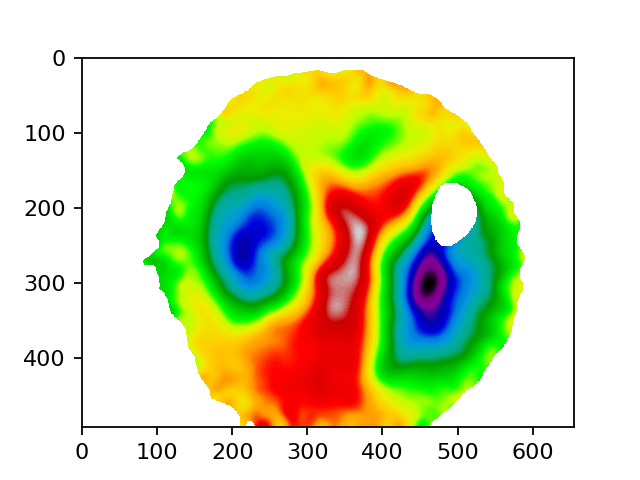

In [25]:
azi_lin[np.isnan(azi_mag)] = np.nan
alt_lin[np.isnan(azi_mag)] = np.nan

pl.figure(figsize=(4,3))
pl.imshow(azi_lin, cmap='nipy_spectral')

# Select colormap

In [26]:
import cmasher as cmr

In [32]:
cmap_phase = pl.get_cmap('cmr.guppy')

In [151]:
# Load colormap
colormap =  'roma' #'nic_Edge' #'romaO'
cmapdir = '/n/coxfs01/julianarhee/colormaps'
cdata = np.loadtxt(os.path.join(cmapdir, colormap) + ".txt")
cmap_phase = LinearSegmentedColormap.from_list('my_colormap', cdata[::-1])

# PLOT.

<IPython.core.display.Javascript object>


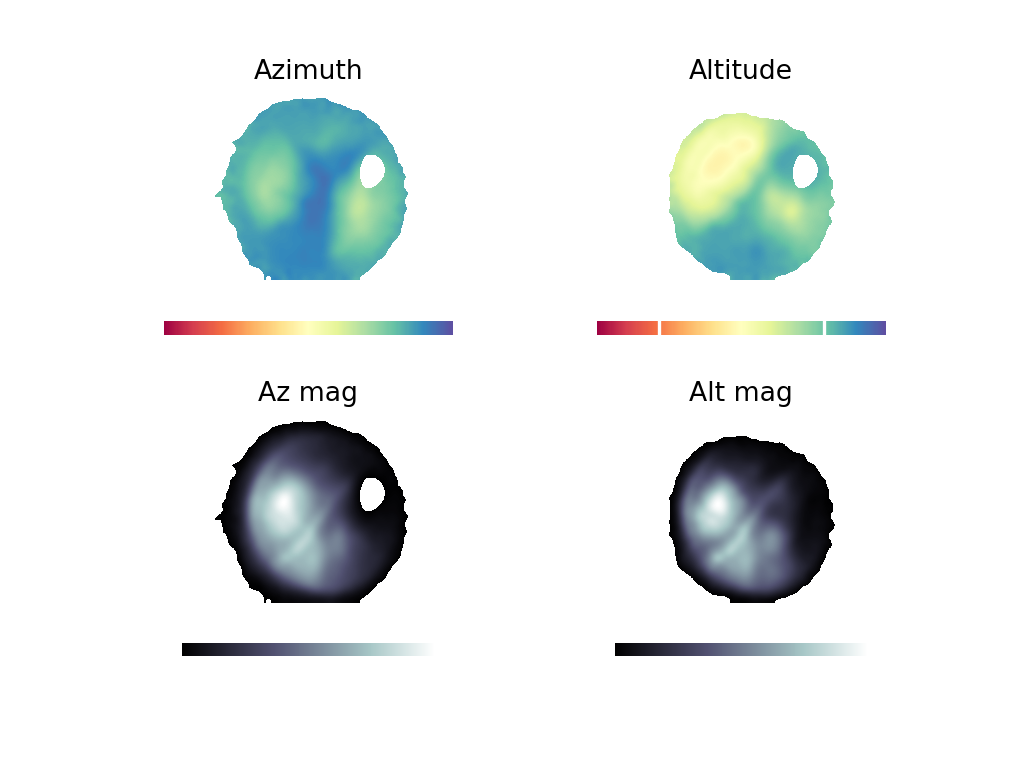

In [158]:
#cmap_phase = pl.get_cmap('cmr.guppy')

az_wf = azi_lin.copy()
az_wf[np.isnan(azi_mag)] = np.nan
el_wf = alt_lin.copy()
el_wf[np.isnan(alt_mag)] = np.nan

cmap='Spectral' #sns.color_palette("Spectral", as_cmap=True)  ##cmap_phase ##'hsv'

fig = pl.figure()
fig.add_subplot(221)
pl.title('Azimuth')
pl.imshow(az_wf, cmap=cmap, vmin=lmin_azi, vmax=lmax_azi)
pl.colorbar(orientation='horizontal', shrink=0.8)

fig.add_subplot(222)
pl.title('Altitude')
pl.imshow(el_wf, cmap=cmap, vmin=lmin_alt, vmax=lmax_alt)
cb = pl.colorbar(orientation='horizontal', shrink=0.8)

screen_lim_pos = screen_h_max/lmax_alt #(lmax_alt-screen_h_max)/(lmax_alt*2.)
cb.ax.axvline(x=screen_lim_pos*lmax_alt, color='w') # my data is between 0 and 1
cb.ax.axvline(x=screen_lim_pos*lmin_alt, color='w') # my data is between 0 and 1

fig.add_subplot(223)
pl.title('Az mag')
pl.imshow(azi_mag, cmap='bone') #, vmin=lmin_alt, vmax=lmax_alt)
cb = pl.colorbar(orientation='horizontal', shrink=0.7)

fig.add_subplot(224)
pl.title('Alt mag')
pl.imshow(alt_mag, cmap='bone') #, vmin=lmin_alt, vmax=lmax_alt)
cb = pl.colorbar(orientation='horizontal', shrink=0.7)
# cb.ax.set_ticks(np.linspace(0, 0.15, 3))

for ax in fig.axes:
    ax.axis('off')

In [20]:
lmin_alt, lmax_alt

(-58.5, 58.5)

# 2p data

In [43]:
import pandas as pd

In [44]:
def get_final_maps(magratios_soma, phases_soma, trials_by_cond=None, mag_thr=0.01, delay_thr=0.5,
                   dims=(512, 512), ds_factor=2, use_pixels=False):
    
    # Get absolute maps from conditions
    magmaps, absolute_az, absolute_el, delay_az, delay_el = absolute_maps_from_conds(
                            magratios_soma, phases_soma, trials_by_cond=trials_by_cond,
                            mag_thr=magthr_2p, dims=(d1_orig, d2_orig),
                            ds_factor=ds_factor, return_map=use_pixels)
    
    # #### Filter where delay map is not uniform (Az v El)
    filt_az, filt_el = filter_by_delay_map(absolute_az, absolute_el,
                                delay_az, delay_el,
                                delay_map_thr=delay_map_thr, return_delay=False)
    phases_by_cond = pd.DataFrame({'phase_az': filt_az, 'phase_el': filt_el})

    #### Mean mag ratios
    if isinstance(magmaps, dict):
        magmaps = pd.concat(magmaps, axis=1)
    mags_by_cond = pd.DataFrame(magmaps[['right', 'left']].mean(axis=1), columns=['mag_az'])
    mags_by_cond['mag_el'] = magmaps[['top', 'bottom']].mean(axis=1)
    
    #### Reprt
    ntotal = absolute_az.shape[0]
    n_pass_magthr = absolute_az.dropna().shape[0]
    n_pass_delaythr = filt_az.dropna().shape[0]
    print("Total: %i\n After mag_thr (%.3f): %i\n After delay_thr (%.3f): %i" \
          % (ntotal, magthr_2p, n_pass_magthr, delay_map_thr, n_pass_delaythr))
    
    df = pd.concat([phases_by_cond, mags_by_cond], axis=1)
    
    return df #filt_az, filt_e, 

In [45]:
# -----------------------------------------------------------------------------
# Map funcs
# -----------------------------------------------------------------------------
def correct_phase_wrap(phase):

    corrected_phase = phase.copy()

    corrected_phase[phase<0] =- phase[phase<0]
    corrected_phase[phase>0] = (2*np.pi) - phase[phase>0]

    return corrected_phase

def arrays_to_maps(magratio, phase, trials_by_cond, use_cont=False,
                            dims=(512, 512), ds_factor=2, cond='right',
                            mag_thr=None, mag_perc=0.05, return_map=True):
    if mag_thr is None:
        mag_thr = magratio.max().max()*mag_perc

    currmags = magratio[trials_by_cond[cond]].copy()
    currmags_mean = currmags.mean(axis=1)
    currmags_mean.loc[currmags_mean<mag_thr] = np.nan 
    #currmags_mean = means_[means_>=mag_thr]

    if return_map:
        d1 = int(dims[0] / ds_factor)
        d2 = int(dims[1] / ds_factor)
        # print(d1, d2)
        currmags_map = np.reshape(currmags_mean.values, (d1, d2))
    else:
        currmags_map = currmags_mean.copy()
        
    currphase = phase[trials_by_cond[cond]].copy() #.loc[currmags_mean.index]
    currphase.loc[currmags_mean[np.isnan(currmags_mean)].index, trials_by_cond[cond]] = np.nan
    #currphase_mean = stats.circmean(currphase, low=-np.pi, high=np.pi, axis=1, nan_policy='omit')
    #currphase_mean_c = correct_phase_wrap(currphase_mean)
    non_nan_ix = currphase.dropna().index #.tolist()
    print("%i non-nan of %i (thr=%.3f)" % (len(non_nan_ix), len(currphase), mag_thr))
    currphase_mean0 = stats.circmean(currphase.dropna(), low=-np.pi, high=np.pi, axis=1) #, nan_policy='omit')
    currphase_mean_c0 = correct_phase_wrap(currphase_mean0)
    currphase_mean_c = pd.DataFrame(data=np.ones(len(currphase),)*np.nan, index=currphase.index)
    currphase_mean_c.loc[non_nan_ix, 0] = currphase_mean_c0

    if return_map:
        #currphase_mean_c[np.isnan(currmags_mean)] = np.nan
        currphase_map_c = np.reshape(currphase_mean_c.values, (d1, d2))
    else:
        currphase_map_c = currphase_mean_c.copy()
        
    return currmags_map, currphase_map_c, mag_thr

def absolute_maps_from_conds(magratio, phase, trials_by_cond=None, mag_thr=0.01,
                                dims=(512, 512), ds_factor=2, return_map=True):
    use_cont=False # doens't matter, should be equiv now
    magmaps = {}
    phasemaps = {}
    magthrs = {}
    if trials_by_cond is not None:
        for cond in trials_by_cond.keys():
            magmaps[cond], phasemaps[cond], magthrs[cond] = arrays_to_maps(
                                                        magratio, phase, trials_by_cond,
                                                        cond=cond, use_cont=use_cont,
                                                        mag_thr=mag_thr, dims=dims,
                                                        ds_factor=ds_factor, return_map=return_map)
    else:
        non_nan_ix = magratio[magratio<mag_thr].dropna().index.tolist()
        magmaps = magratio.copy()
        magmaps.loc[non_nan_ix] = np.nan
        
        phasemaps = phase.apply(correct_phase_wrap) # make continuous, from 0 to 2pi
        phasemaps.loc[non_nan_ix] = np.nan
        
    ph_left = phasemaps['left'].copy()
    ph_right = phasemaps['right'].copy()
    ph_top = phasemaps['top'].copy()
    ph_bottom = phasemaps['bottom'].copy()
    print("got phase:", np.nanmin(ph_left), np.nanmax(ph_left)) # (0, 2*np.pi)

    absolute_az = (ph_left - ph_right) / 2.
    delay_az = (ph_left + ph_right) / 2.

    absolute_el = (ph_bottom - ph_top) / 2.
    delay_el = (ph_bottom + ph_top) / 2.

    vmin, vmax = (-np.pi, np.pi) # Now in range (-np.pi, np.pi)
    print("got absolute:", np.nanmin(absolute_az), np.nanmax(absolute_az))
    print("Delay:", np.nanmin(delay_az), np.nanmax(delay_az))

    return magmaps, absolute_az, absolute_el, delay_az, delay_el

def filter_by_delay_map(absolute_az, absolute_el, delay_az, delay_el, delay_map_thr=0.5, 
                        return_delay=True):
    delay_diff = abs(delay_az-delay_el)

    filt_az = absolute_az.copy()
    filt_az[delay_diff>delay_map_thr] = np.nan

    filt_el = absolute_el.copy()
    filt_el[delay_diff>delay_map_thr] = np.nan

    delay_filt = delay_diff.copy()
    delay_filt[delay_diff>delay_map_thr] = np.nan

    if return_delay:
        return filt_az, filt_el, delay_diff
    else:
        return filt_az, filt_el
    

In [46]:
def rotate_image(mat, angle):
    """
    Rotates an image (angle in degrees) and expands image to avoid cropping
    """

    height, width = mat.shape
    image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0])
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))
    return rotated_mat

def transform_2p_fov(img, pixel_size, zoom_factor=1., normalize=True):
    '''
    First, left/right reflection and rotation of 2p image to match orientation of widefield view.
    Then, scale image to pixel size as measured by PSF.
    '''
    transf_ = orient_2p_to_macro(img, zoom_factor=zoom_factor, save=False, normalize=normalize)
    scaled_ = scale_2p_fov(transf_, pixel_size=pixel_size)
    return scaled_

def orient_2p_to_macro(avg, zoom_factor, normalize=True,
                    acquisition_dir='/tmp', channel_ix=0, plot=False, save=True): #,
                        #xaxis_conversion=2.312, yaxis_conversion=1.904):
    '''
    Does standard Fiji steps:
        1. Scale slow-angle (if needed)
        2. Rotate image leftward, and flip L/R ('horizontally' in Fiji)
        3. Convert to 8-bit and adjust contrast
    '''
    # Scale:
    d1, d2 = avg.shape # (img height, img width)
    
    # dsize: (v1, v2) -- v1 specifies COLS, v2 specifies ROWS (i.e., img_w, img_h)
    scaled = cv2.resize(avg, dsize=(int(d1*zoom_factor), d2), interpolation=cv2.INTER_CUBIC)  #, dtype=avg.dtype)

    # Rotate leftward:
    rotated = rotate_image(scaled, 90)

    # Flip L/R:
    transformed = np.fliplr(rotated)

    # Cut off super low vals, Convert range from 0, 255
    if normalize:
        transformed[transformed<-50] = 0
        normed = cv2.normalize(transformed, None, 0, 255, cv2.NORM_MINMAX)

        # Convert to 8-bit
        img8 = cv2.convertScaleAbs(normed)

        # Equalize hist:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(10,10))
        eq = clahe.apply(img8)
    else:
        eq = transformed.copy()

    if normalize:
        return img8 #eq #transformed_img_path
    else:
        return eq
    
def scale_2p_fov(transformed_image, pixel_size=(2.312, 1.888)):
    xaxis_conversion, yaxis_conversion = pixel_size

    d1, d2 = transformed_image.shape # d1=HEIGHT, d2=WIDTH
    new_d1 = int(round(d1*xaxis_conversion,1)) # yaxis corresponds to M-L axis (now along )
    new_d2 = int(round(d2*yaxis_conversion,1)) # xaxis corresopnds to A-P axis (d2 is iamge width)
    im_r = cv2.resize(transformed_image, (new_d2, new_d1))

    return im_r

In [47]:
# #####################################
# retinotopy/utils.py()

def load_fov_image(RETID):

    ds_factor = int(RETID['PARAMS']['downsample_factor'])

    # Load reference image
    imgs = glob.glob(os.path.join('%s*' % RETID['SRC'], 'std_images.tif'))[0]
    #imgs = glob.glob(os.path.join(rootdir, animalid, session, fov, retinorun, 'processed',\
    #                      'processed001*', 'mcorrected_*', 'std_images.tif'))[0]
    zimg = tf.imread(imgs)
    zimg = zimg.mean(axis=0)

    if ds_factor is not None:
        zimg = block_mean(zimg, int(ds_factor))

    print("... FOV size: %s (downsample factor=%i)" % (str(zimg.shape), ds_factor))

    return zimg

def load_mw_info(animalid, session, fov, run_name='retino', rootdir='/n/coxfs01/2p-data'):
    parsed_fpaths = glob.glob(os.path.join(rootdir, animalid, session, fov,
                                    '%s*' % run_name,
                                    'paradigm', 'files', 'parsed_trials*.json'))
    assert len(parsed_fpaths)==1, "Unable to find correct parsed trials path: %s" % str(parsed_fpaths)
    with open(parsed_fpaths[0], 'r') as f:
        mwinfo = json.load(f)

    return mwinfo


def get_protocol_info(animalid, session, fov, run='retino_run1', rootdir='/n/coxfs01/2p-data'):

    run_dir = os.path.join(rootdir, animalid, session, fov, run)
    mwinfo = load_mw_info(animalid, session, fov, run, rootdir=rootdir)

    si_fpath = glob.glob(os.path.join(run_dir, '*.json'))[0]
    with open(si_fpath, 'r') as f:
        scaninfo = json.load(f)

    conditions = list(set([cdict['stimuli']['stimulus'] for trial_num, cdict in mwinfo.items()]))
    trials_by_cond = dict((cond, [int(k) for k, v in mwinfo.items() if v['stimuli']['stimulus']==cond]) \
                           for cond in conditions)
    n_frames = scaninfo['nvolumes']
    fr = scaninfo['frame_rate']

    stiminfo = dict((cond, dict()) for cond in conditions)
    curr_cond = conditions[0]
    # get some info from paradigm and run file
    stimfreq = np.unique([v['stimuli']['scale'] for k,v in mwinfo.items() if v['stimuli']['stimulus']==curr_cond])[0]
    stimperiod = 1./stimfreq # sec per cycle

    n_cycles = int(round((n_frames/fr) / stimperiod))
    n_frames_per_cycle = int(np.floor(stimperiod * fr))
    cycle_starts = np.round(np.arange(0, n_frames_per_cycle * n_cycles, n_frames_per_cycle)).astype('int')

    # Get frequency info
    freqs = np.fft.fftfreq(n_frames, float(1./fr))
    sorted_idxs = np.argsort(freqs)
    freqs = freqs[sorted_idxs] # sorted
    freqs = freqs[int(np.round(n_frames/2.))+1:] # exclude DC offset from data
    stim_freq_idx = np.argmin(np.absolute(freqs - stimfreq)) # Index of stimulation frequency

    stiminfo = {'stim_freq': stimfreq,
               'frame_rate': fr,
               'n_reps': len(trials_by_cond[curr_cond]),
               'n_frames': n_frames,
               'n_cycles': n_cycles,
               'n_frames_per_cycle': n_frames_per_cycle,
               'cycle_start_ixs': cycle_starts,
               'stim_freq_idx': stim_freq_idx,
               'freqs': freqs}

    scaninfo.update({'stimulus': stiminfo})
    scaninfo.update({'trials': trials_by_cond})


    return scaninfo

def load_retino_analysis_info(animalid, session, fov, run='retino', retinoid=None, 
                              use_pixels=False, rootdir='/n/coxfs01/2p-data'):

    run_dir = glob.glob(os.path.join(rootdir, animalid, session, '%s*' % fov, '%s*' % run))[0]
    fov = os.path.split(os.path.split(run_dir)[0])[-1]

    retinoids_fpath = glob.glob(os.path.join(run_dir, 'retino_analysis', 'analysisids_*.json'))[0]
    with open(retinoids_fpath, 'r') as f:
        rids = json.load(f)
    if use_pixels:
        roi_analyses = [r for r, rinfo in rids.items() if rinfo['PARAMS']['roi_type'] == 'pixels']
    else:
        roi_analyses = [r for r, rinfo in rids.items() if rinfo['PARAMS']['roi_type'] != 'pixels']
    if retinoid not in roi_analyses:
        retinoid = sorted(roi_analyses, key=natural_keys)[-1] # use most recent roi analysis

    return retinoid, rids[retinoid]


# --------------------------------------------------------------
# -- if use_pixels=True
# --------------------------------------------------------------

def fft_results_by_trial(RETID):

    run_dir = RETID['DST'].split('/retino_analysis/')[0]
    processed_filepaths = glob.glob(os.path.join(RETID['DST'], 'files', '*h5'))
    trialinfo_filepath = glob.glob(os.path.join(run_dir, 'paradigm',
                                    'files', 'parsed_trials*.json'))[0]
    _, magratio, phase, trials_by_cond = trials_to_dataframes(processed_filepaths,
                                                trialinfo_filepath)
    return magratio, phase, trials_by_cond

def trials_to_dataframes(processed_fpaths, conditions_fpath):

    # Get condition / trial info:
    with open(conditions_fpath, 'r') as f:
        conds = json.load(f)
    cond_list = list(set([cond_dict['stimuli']['stimulus'] for trial_num, cond_dict in conds.items()]))
    trials_by_cond = dict((cond, [int(k) for k, v in conds.items() \
                                  if v['stimuli']['stimulus']==cond]) for cond in cond_list)

    excluded_tifs = []
    for cond, tif_list in trials_by_cond.items():
        for tifnum in tif_list:
            processed_tif = [f for f in processed_fpaths if 'File%03d' % tifnum in f]
            if len(processed_tif) == 0:
                print("No analysis found for file: %s" % tifnum)
                excluded_tifs.append(tifnum)
        trials_by_cond[cond] = [t for t in tif_list if t not in excluded_tifs]
    trial_list = [int(t) for t in conds.keys() if int(t) not in excluded_tifs]

    fits = []
    phases = []
    mags = []
    for trial_num, trial_fpath in zip(sorted(trial_list), sorted(processed_fpaths, key=natural_keys)):

        #print("%i: %s" % (trial_num, os.path.split(trial_fpath)[-1]))
        df = h5py.File(trial_fpath, 'r')
        fits.append(pd.Series(data=df['var_exp_array'][:], name=trial_num))
        phases.append(pd.Series(data=df['phase_array'][:], name=trial_num))
        mags.append(pd.Series(data=df['mag_ratio_array'][:], name=trial_num))
        df.close()

    fit = pd.concat(fits, axis=1)
    magratio = pd.concat(mags, axis=1)
    phase = pd.concat(phases, axis=1)

    return fit, magratio, phase, trials_by_cond

In [48]:
# #####################################
# from ./retinotopy/utils.py
# #####################################

# --------------------------------------------------------------
# Only works with roi traces
# --------------------------------------------------------------
# 
#import dill as pkl
def extract_from_fft_results(fft_soma):
    '''
    Return magratios_soma, phases_soma
    '''
    # Create dataframe of magratios -- each column is a condition
    magratios_soma = pd.DataFrame(dict((cond, k[0]) for cond, k in fft_soma.items()))
    phases_soma = pd.DataFrame(dict((cond, k[1]) for cond, k in fft_soma.items()))
    return magratios_soma, phases_soma


def load_fft_results(animalid, session, fov, retinorun='retino_run1', trace_type='corrected',
                    traceid='traces001', create_new=False,
                     detrend_after_average=True, in_negative=False,
                     rootdir='/n/coxfs01/2p-data'):

    run_dir = os.path.join(rootdir, animalid, session, fov, retinorun)
    try:
        # RETID = load_retinoanalysis(run_dir, traceid)
        retinoid, RETID = load_retino_analysis_info(animalid, session, fov, use_pixels=False)

        assert RETID is not None
    except Exception as e:
        print("NO retino for traceid %s\n(check dir: %s)" % (traceid, run_dir))
        return None

    analysis_dir = RETID['DST']
    retinoid = RETID['analysis_id']
    print("... Loaded: %s, %s (%s))" % (retinorun, retinoid, run_dir))

    fft_dpath=os.path.join(analysis_dir, 'fft_results_%s.pkl' % retinoid)
    if create_new is False:
        try:
            with open(fft_dpath, 'rb') as f:
                fft_results = pkl.load(f)
        except Exception as e:
            create_new=True

    if create_new:

        # Load MW info and SI info
        mwinfo = load_mw_info(animalid, session, fov, retinorun)
        scaninfo = get_protocol_info(animalid, session, fov, run=retinorun) # load_si(run_dir)
        tiff_paths = tiff_fpaths = sorted(glob.glob(os.path.join(RETID['SRC'], '*.tif')), key=natural_keys)
        print("Found %i tifs" % len(tiff_paths))

        # Some preprocessing params
        temporal_ds = float(RETID['PARAMS']['average_frames'])
        print("Temporal ds: %.2f" % (temporal_ds))

        #### Load raw and process traces -- returns average trace for condition
        # retino_dpath = os.path.join(analysis_dir, 'traces', 'extracted_traces.h5')
        np_traces = load_roi_traces(animalid, session, fov, run=retinorun,
                        analysisid=retinoid, trace_type='neuropil', detrend_after_average=detrend_after_average)
        soma_traces = load_roi_traces(animalid, session, fov, run=retinorun,
                        analysisid=retinoid, trace_type=trace_type, detrend_after_average=detrend_after_average)

        # Do fft
        n_frames = scaninfo['stimulus']['n_frames']
        frame_rate = scaninfo['stimulus']['frame_rate']
        stim_freq_idx = scaninfo['stimulus']['stim_freq_idx']

        #### label frequency bins
        freqs = np.fft.fftfreq(n_frames, float(1./frame_rate))
        sorted_freq_idxs = np.argsort(freqs)

        sign = -1 if in_negative else 1
        
        fft_soma = dict((cond, do_fft_analysis(sign*tdf, sorted_freq_idxs, stim_freq_idx)) \
                        for cond, tdf in soma_traces.items())
        fft_np=None
        if use_pixels is False:
            fft_np = dict((cond, do_fft_analysis(tdf, sorted_freq_idxs, stim_freq_idx)) \
                      for cond, tdf in np_traces.items())

        fft_results = {'fft_soma': fft_soma, 'fft_neuropil': fft_np,
                       'scaninfo': scaninfo, 'RETID': RETID}

        #### Save output
        with open(fft_dpath, 'wb') as f:
            pkl.dump(fft_results, f, protocol=2)

    return fft_results


def do_fft_analysis(avg_traces, sorted_idxs, stim_freq_idx):
    n_frames = avg_traces.shape[0]

    fft_results = np.fft.fft(avg_traces, axis=0) #avg_traces.apply(np.fft.fft, axis=1)

    # get phase and magnitude
    mag_data = abs(fft_results)
    phase_data = np.angle(fft_results)

    # sort mag and phase by freq idx:
    mag_data = mag_data[sorted_idxs]
    phase_data = phase_data[sorted_idxs]

    # exclude DC offset from data
    if len(mag_data.shape)==1:
        mag_data = mag_data[int(np.round(n_frames/2.))+1:]
        phase_data = phase_data[int(np.round(n_frames/2.))+1:]
        #unpack values from frequency analysis
        mag_array = mag_data[stim_freq_idx]
        phase_array = phase_data[stim_freq_idx]
    else:
        mag_data = mag_data[int(np.round(n_frames/2.))+1:, :]
        phase_data = phase_data[int(np.round(n_frames/2.))+1:, :]

        #unpack values from frequency analysis
        mag_array = mag_data[stim_freq_idx, :]
        phase_array = phase_data[stim_freq_idx, :]

    #get magnitude ratio
    tmp = np.copy(mag_data)
    #tmp = np.delete(tmp,freq_idx,0)
    nontarget_mag_array=np.sum(tmp,0)
    magratio_array=mag_array/nontarget_mag_array

    return magratio_array, phase_array


In [49]:
# preprocessing ---------------
def load_roi_traces(animalid, session, fov, run='retino_run1', analysisid='analysis002',
                trace_type='corrected', detrend_after_average=True, rootdir='/n/coxfs01/2p-data'):
    print("... loading traces (%s)" % trace_type)
    retinoid_path = glob.glob(os.path.join(rootdir, animalid, session, fov, '%s*' % run,
                                'retino_analysis', 'analysisids_*.json'))[0]
    with open(retinoid_path, 'r') as f:
        RIDS = json.load(f)
    eligible = [r for r, res in RIDS.items() if res['PARAMS']['roi_type']!='pixels']
    if analysisid not in eligible:
        print("Specified ID <%s> not eligible. Selecting 1st of %s"
                    % (analysisid, str(eligible)))
        analysisid = eligible[0]

    analysis_dir = RIDS[analysisid]['DST']
    print("... loading traces from: %s" % analysis_dir)
    retino_dpath = os.path.join(analysis_dir, 'traces', 'extracted_traces.h5')
    scaninfo = get_protocol_info(animalid, session, fov, run=run)
    temporal_ds = RIDS[analysisid]['PARAMS']['downsample_factor']
    traces = load_roi_traces_from_file(retino_dpath, scaninfo, trace_type=trace_type,
                                    temporal_ds=temporal_ds, detrend_after_average=detrend_after_average)
    return traces

def load_roi_traces_from_file(retino_dpath, scaninfo, trace_type='corrected',
                            temporal_ds=None, detrend_after_average=False):
    '''
    Pre-processes raw extracted traces by:
        - adding back in neuropil offsets, and
        - F0 offset from drift correction.
    Loads: ./traces/extracted_traces.h5 (contains data for each tif file).
    Averages traces for each condition. Downsamples final array.
    '''
    frame_rate = scaninfo['stimulus']['frame_rate']
    stim_freq = scaninfo['stimulus']['stim_freq']
    trials_by_cond = scaninfo['trials']

    traces = {}
    try:
        tfile = h5py.File(retino_dpath, 'r')
        for condition, trialnums in trials_by_cond.items():
            #print("... loading cond: %s" % condition)
            do_detrend = detrend_after_average is False
            dlist = tuple([process_data(tfile, trialnum, trace_type=trace_type, \
                        frame_rate=frame_rate, stim_freq=stim_freq, detrend=do_detrend) \
                        for trialnum in trialnums])
            dfcat = pd.concat(dlist)
            df_rowix = dfcat.groupby(dfcat.index)
            # Average raw traces together
            meandf = df_rowix.mean()

            # detrend
            if detrend_after_average:
                f0 = meandf.mean() #.mean()
                drift_corr = detrend_array(meandf, frame_rate=frame_rate, stim_freq=stim_freq)
                meandf = drift_corr + f0

            # smooth
            if temporal_ds is not None:
                #print("Temporal ds: %.2f" % temporal_ds)
                meandf = downsample_array(meandf, temporal_ds=temporal_ds)
            traces[condition] = meandf
    except Exception as e:
        traceback.print_exc()
    finally:
        tfile.close()

    return traces

def process_data(tfile, trialnum, trace_type='corrected', add_offset=True, #'corrected', add_offset=True,
                frame_rate=44.65, stim_freq=0.13, correction_factor=0.7, detrend=True):
    #print(tfile['File001'].keys())
    if trace_type != 'neuropil' and add_offset:
        # Get raw soma traces and raw neuropil -- add neuropil offset to soma traces
        # print(tfile['File%03d' % int(trialnum)].keys())
        # trace_types:  corrected, neuropil, processed, raw (+ masks)
        soma = pd.DataFrame(tfile['File%03d' % int(trialnum)][trace_type][:].T)
        neuropil = pd.DataFrame(tfile['File%03d' % int(trialnum)]['neuropil'][:].T)
        np_offset = neuropil.mean(axis=0) #neuropil.mean().mean()
        if trace_type=='raw':
            #print("raw")
            xd = soma.subtract(correction_factor*neuropil) + np_offset
        else:
            xd = soma + np_offset
        del neuropil
        del soma
    else:
        xd = pd.DataFrame(tfile['File%03d' % int(trialnum)][trace_type][:].T)

    if detrend:
        f0 = xd.mean() #.mean()
        drift_corrected = detrend_array(xd, frame_rate=frame_rate, stim_freq=stim_freq)
        xdata = drift_corrected + f0
    else:
        xdata = xd.copy()
    #if temporal_ds is not None:
    #    xdata = downsample_array(xdata, temporal_ds=temporal_ds)

    return xdata

def subtract_rolling_mean(trace, windowsz):
    #print(trace.shape)
    tmp1 = np.concatenate((np.ones(windowsz)*trace.values[0], trace, np.ones(windowsz)*trace.values[-1]),0)
    rolling_mean = np.convolve(tmp1, np.ones(windowsz)/windowsz, 'same')
    rolling_mean=rolling_mean[windowsz:-windowsz]
    return np.subtract(trace, rolling_mean)

def detrend_array(roi_trace, frame_rate=44.65, stim_freq=0.24):
    #print('Removing rolling mean from traces...')
    windowsz = int(np.ceil((np.true_divide(1,stim_freq)*3)*frame_rate))
    detrend_roi_trace = roi_trace.apply(subtract_rolling_mean, args=(windowsz,), axis=0)
    return detrend_roi_trace #pd.DataFrame(detrend_roi_trace)

def temporal_downsample(trace, windowsz):
    tmp1=np.concatenate((np.ones(windowsz)*trace.values[0], trace, np.ones(windowsz)*trace.values[-1]),0)
    tmp2=np.convolve(tmp1, np.ones(windowsz)/windowsz, 'same')
    tmp2=tmp2[windowsz:-windowsz]
    return tmp2


def downsample_array(roi_trace, temporal_ds=5):
    #print('Performing temporal smoothing on traces...')
    windowsz = int(temporal_ds)
    smooth_roi_trace = roi_trace.apply(temporal_downsample, args=(windowsz,), axis=0)
    return smooth_roi_trace



In [50]:
from scipy.ndimage.morphology import binary_dilation
from scipy import ndimage

def get_kernel(kernel_size):
    kernel_radius = (kernel_size - 1) // 2
    x, y = np.ogrid[-kernel_radius:kernel_radius+1, -kernel_radius:kernel_radius+1]
    dist = (x**2 + y**2)**0.5 # shape (kernel_size, kernel_size)

    # let's create three kernels for the sake of example
    radii = np.array([kernel_size/3., kernel_size/2.5, kernel_size/2.])[...,None,None] # shape (num_radii, 1, 1)
    # using ... allows compatibility with arbitrarily-shaped radius arrays

    kernel = (1 - (dist - radii).clip(0,1)).sum(axis=0)
    return kernel

def dilate_mask_centers(maskcenters, kernel_size=9):
    '''Calculate center of soma, then dilate to create masks for smoothed  neuropil
    '''
#     a = np.zeros((5, 5))
#     struct1 = ndimage.generate_binary_structure(2, 1)   
#     kernel = ndimage.binary_dilation(a, structure=struct1, iterations=sigma).astype(a.dtype)
    
    kernel = get_kernel(kernel_size)
    dilated_masks = np.zeros(maskcenters.shape, dtype=maskcenters.dtype)
    for roi in range(maskcenters.shape[0]):
        img = maskcenters[roi, :, :].copy()
        x, y = np.where(img>0)
        centroid = ( int(round(sum(x) / len(x))), int(round(sum(y) / len(x))) )
        # print(centroid)
        np_tmp = np.zeros(img.shape, dtype=bool)
        np_tmp[centroid] = True
        dilation = binary_dilation(np_tmp, structure=kernel )
        dilated_masks[roi, : :] = dilation
    return dilated_masks


def get_roi_centroids(masks):
    '''Calculate center of soma, then return centroid coords.
    '''
    centroids=[]
    for roi in range(masks.shape[0]):
        img = masks[roi, :, :].copy()
        x, y = np.where(img>0)
        centroid = ( round(sum(x) / len(x)), round(sum(y) / len(x)) )
        centroids.append(centroid)
    
    nrois_total = masks.shape[0]
    ctr_df = pd.DataFrame(centroids, columns=['x', 'y'], index=range(nrois_total))

    return ctr_df

def mask_rois(masks, value_array, mask_thr=0.1, return_array=False):
    '''
    dim 0 of mask_array (nrois, d1, d2) must be same as len(value_array)
    OR, value_array should be a dataframe with included rois, used to index into full masks array
    Indices of value_array (dataframe) should correspond actual index in masks.
    '''
    nr, d1_, d2_ = masks.shape
    dims = (d1_, d2_)

    if return_array:
        value_mask = np.ones(masks.shape)*np.nan #-100
        for rid in value_array.index.tolist():
            value_mask[rid, masks[rid,:,:]>=mask_thr] = value_array.loc[rid]

    else:
        value_mask =  np.ones(dims)*-100
        for rid in value_array.index.tolist():
            value_mask[masks[rid,:,:]>=mask_thr] = value_array.loc[rid]

    return value_mask

def mask_with_overlaps_averaged(dilated_masks, value_array, mask_thr=0.1):
    nt, d1_, d2_ = dilated_masks.shape
    
    # Get non-averaged array
    tmpmask = mask_rois(dilated_masks, value_array, mask_thr=mask_thr, return_array=False)
    
    # Get full array to average across overlapping pixels
    tmpmask_full = mask_rois(dilated_masks, value_array, mask_thr=mask_thr, return_array=True)
    tmpmask_r = np.reshape(tmpmask_full, (nt, d1_*d2_))
    
    # Replace overlapping pixels with average value
    avg_mask = tmpmask.copy().ravel()
    multi_ixs = [i for i in range(tmpmask_r.shape[-1]) if len(np.where(tmpmask_r[:, i])[0]) > 1]
    for ix in multi_ixs:
        #avg_azim[ix] = spstats.circmean([v for v in azim_phase2[:, ix] if not np.isnan(v)], low=vmin, high=vmax)
        avg_mask[ix] = np.nanmean([v for v in tmpmask_r[:, ix] if not np.isnan(v)])#, low=vmin, high=vmax)

    avg_mask = np.reshape(avg_mask, (d1_, d2_))

    return avg_mask


def get_phase_masks(masks, azim, elev, average_overlap=True, roi_list=None): #, use_cont=True, mask_thr=0.01):
#     # Convert phase to continuous:
#     phases_cont = -1 * phases
#     phases_cont = phases_cont % (2*np.pi)
    
    # Only include specified rois:
    if roi_list is None:
        roi_list = azim.index.tolist()
        
#     # Get absolute maps:
#     if use_cont:
#         elev = (phases_cont['bottom'] - phases_cont['top']) / 2.
#         azim = (phases_cont['left'] - phases_cont['right']) / 2.
#         vmin = -np.pi
#         vmax = np.pi
#     else:
#         # Get absolute maps:
#         elev = (phases['bottom'] - phases['top']) / 2.
#         azim = (phases['left'] - phases['right']) / 2.
        
#         # Convert to continueous:
#         elev_c = -1 * elev
#         elev_c = elev_c % (2*np.pi)
#         azim_c = -1 * azim
#         azim_c = azim_c % (2*np.pi)

#         vmin = 0
#         vmax = 2*np.pi

#         azim = copy.copy(azim_c)
#         elev = copy.copy(elev_c)
        
    if average_overlap:
        azim_phase = mask_with_overlaps_averaged(masks, azim.loc[roi_list]) #, mask_thr=mask_thr)
        elev_phase = mask_with_overlaps_averaged(masks, elev.loc[roi_list]) #, mask_thr=mask_thr)
    else:
        azim_phase = mask_rois(masks, azim.loc[roi_list]) #, mask_thr=mask_thr)
        elev_phase = mask_rois(masks, elev.loc[roi_list]) #, mask_thr=mask_thr)   
    
    return azim_phase, elev_phase



In [51]:
import pickle as pkl

In [52]:
#print(animalid)
# session_2p = '20190622' #'20191111'
# retinorun_2p='retino_run1'
animalid = 'JC084'
session_2p = '20190522' #'20191111'
retinorun_2p='retino_run2'

fov = 'FOV1_zoom2p0x'
traceid='traces001'


In [53]:
retinorun_2p

'retino_run2'

In [54]:
# Load FFT data 
use_pixels=False

retinoid, RETID = load_retino_analysis_info(animalid, session_2p, fov, run=retinorun_2p, use_pixels=use_pixels)
retinorun_2p = os.path.split(RETID['DST'].split('/retino_analysis')[0])[-1]
# print("Current run: %s" % retinorun_2p)
data_id = '_'.join([animalid, session_2p, fov, retinorun_2p, retinoid])
print("DATA ID: %s" % data_id)
scaninfo = get_protocol_info(animalid, session_2p, fov, run=retinorun_2p)

# Set animal output dir
animal_dst_dir = os.path.join(RETID['DST'], 'visualization')
if use_pixels:
    magratios_soma, phases_soma, trials_by_cond = fft_results_by_trial(RETID)
else:
    trials_by_cond=None
    fft_results = load_fft_results(animalid, session_2p, fov, retinorun=retinorun_2p, 
                        traceid=traceid, rootdir=rootdir, create_new=False)
#     RETID = fft_results['RETID']
#     scaninfo = fft_results['scaninfo']
    fft_soma = fft_results['fft_soma']
    fft_np = fft_results['fft_neuropil']

    # Create dataframe of magratios -- each column is a condition
    magratios_soma, phases_soma = extract_from_fft_results(fft_soma)
    magratios_np, phases_np = extract_from_fft_results(fft_np)
    

DATA ID: JC084_20190522_FOV1_zoom2p0x_retino_run2_analysis002
... Loaded: retino_run2, analysis002 (/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2))


In [55]:
# Image dimensions
d2_orig = scaninfo['pixels_per_line']
d1_orig = scaninfo['lines_per_frame']
print("Original dims: [%i, %i]" % (d1_orig, d2_orig))
ds_factor = int(RETID['PARAMS']['downsample_factor'])
print('Data were downsampled by %i.' % ds_factor)

# Get pixel size
pixel_size = get_pixel_size()
pixel_size_ds = (pixel_size[0]*ds_factor, pixel_size[1]*ds_factor)
d1 = int(d1_orig/ds_factor)
d2 = int(d2_orig/ds_factor)
print(d1, d2)

Original dims: [512, 512]
Data were downsampled by 2.
256 256


In [56]:
ds_factor

2

In [57]:
trials_by_cond

In [245]:
magthr_2p=0.001
delay_map_thr=1.0
# #### Get maps
# abs_vmin, abs_vmax = (-np.pi, np.pi)

df = get_final_maps(magratios_soma, phases_soma, trials_by_cond=trials_by_cond,
                    mag_thr=magthr_2p, dims=(d1_orig, d2_orig), ds_factor=ds_factor, use_pixels=use_pixels)
print(df.shape)
df.head()

got phase: 0.03176504846398956 6.259183811422113
got absolute: -2.976602122452739 2.610935544796344
Delay: 0.061449006759427896 5.728981060050685
Total: 260
 After mag_thr (0.001): 260
 After delay_thr (1.000): 191
(260, 4)


,phase_az,phase_el,mag_az,mag_el
0,-1.881132,2.569592,0.008531,0.006036
1,1.381939,-0.370347,0.010187,0.007679
2,-0.676140,0.436784,0.007591,0.005196
3,NaN,NaN,0.012789,0.019241
4,NaN,NaN,0.003869,0.002590


In [246]:
magratios_soma.head()

,top,bottom,left,right
0,0.006291,0.005780,0.012314,0.004747
1,0.006775,0.008583,0.009311,0.011062
2,0.004230,0.006162,0.004868,0.010315
3,0.014314,0.024168,0.011044,0.014534
4,0.003110,0.002070,0.001590,0.006147


In [247]:
df_neuropil = get_final_maps(magratios_np, phases_np, trials_by_cond=trials_by_cond,
                    mag_thr=magthr_2p, dims=(d1_orig, d2_orig), ds_factor=ds_factor, use_pixels=use_pixels)
print(df_neuropil.shape)
df_neuropil.head()

got phase: 3.6371586210651676 4.83265532302228
got absolute: 0.3406610940781003 1.391505506057103
Delay: 3.0611539207892013 3.7941696523760164
Total: 260
 After mag_thr (0.001): 260
 After delay_thr (1.000): 260
(260, 4)


,phase_az,phase_el,mag_az,mag_el
0,1.004317,-0.638095,0.030171,0.032829
1,1.134235,-0.686850,0.038640,0.039643
2,1.075843,-0.627319,0.044091,0.044765
3,1.105884,-0.753369,0.034830,0.040343
4,1.046038,-0.720772,0.038394,0.042880


<IPython.core.display.Javascript object>


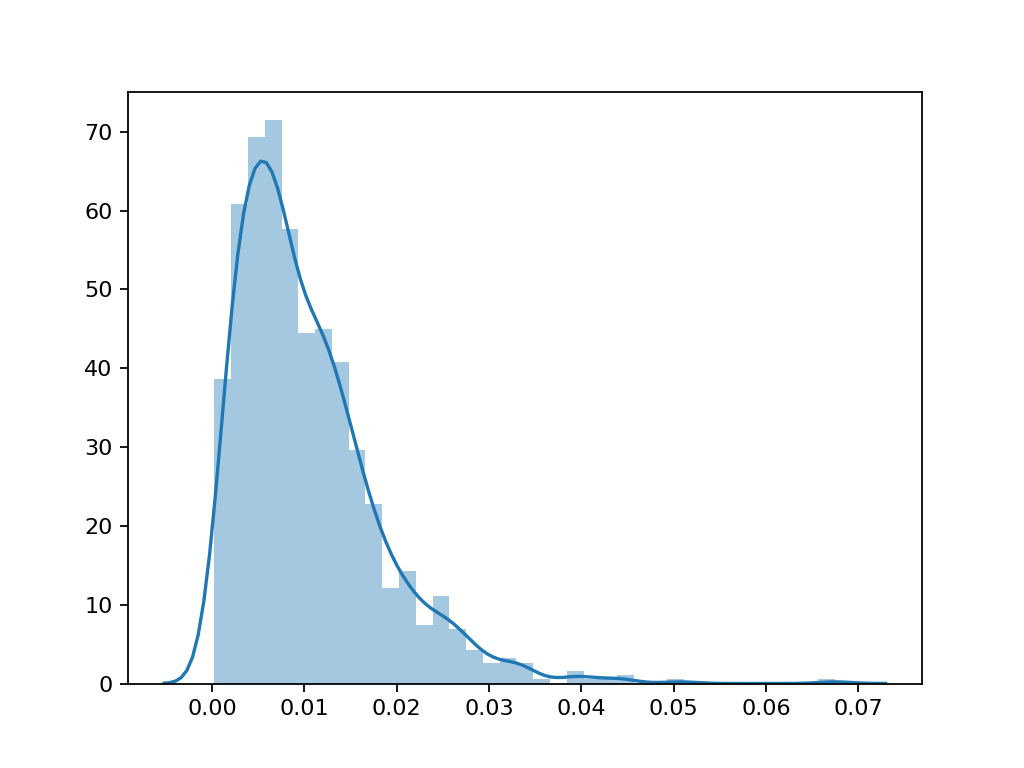

<AxesSubplot:>

In [248]:
pl.figure(figsize=(4,3))
sns.distplot(magratios_soma.dropna().values.ravel())

In [249]:
# zimg = load_fov_image(RETID)
# d1_2p, d2_2p = zimg.shape


#### Load masks

In [63]:
# Get masks
analysis_dir = RETID['DST']
roiid = RETID['PARAMS']['roi_id']
retino_dpath = os.path.join(analysis_dir, 'traces', 'extracted_traces.h5')
tfile = h5py.File(retino_dpath, 'r')

rid_fpath = glob.glob(os.path.join(rootdir, animalid, session_2p, 'ROIs', 'rids*.json'))[0]
with open(rid_fpath, 'r') as f:
    rids = json.load(f)
reffile = rids[roiid]['PARAMS']['options']['ref_file']

masks_np = tfile['File%03d' % int(reffile)]['np_masks'][:].T
print("NP masks:", masks_np.shape)

nrois_total, _ = masks_np.shape
masks_np = np.reshape(masks_np, (nrois_total, d1, d2))
masks_np[masks_np>0] = 1

masks_soma = tfile['File%03d' % int(reffile)]['masks'][:].copy()
masks_soma = np.reshape(masks_soma, (nrois_total, d1, d2))
masks_soma[masks_soma>0] = 1
print(masks_soma.shape)

print( tfile['File%03d' % int(reffile)].keys())

NP masks: (260, 65536)
(260, 256, 256)
<KeysViewHDF5 ['corrected', 'masks', 'neuropil', 'np_masks', 'np_subtracted', 'processed', 'raw']>


#### Dilate masks

In [64]:
um_per_pixel = np.mean(pixel_size)
desired_radius_um = 30.0 # 20.
pixels2dilate = desired_radius_um/um_per_pixel
print(pixels2dilate)
kernel_size = np.ceil(pixels2dilate+2) #21
kernel = get_kernel(kernel_size)

kernel_diam_um = (kernel.shape[0]*um_per_pixel)
print("Dilation diameter (um): %.2f" % kernel_diam_um)

dilated_masks = dilate_mask_centers(masks_soma.astype(float), kernel_size=kernel_size)

14.285714285714288
Dilation diameter (um): 35.70


<IPython.core.display.Javascript object>


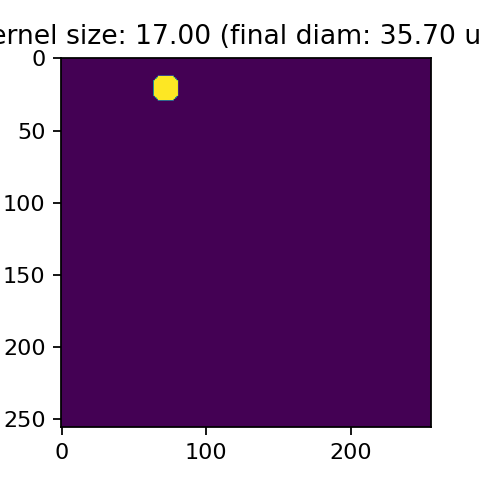

16
16


In [65]:
rid = 4
pl.figure(figsize=(3,3))
pl.imshow(dilated_masks[rid, :, :])
pl.title("Kernel size: %.2f (final diam: %.2f um)" % (kernel_size, kernel_diam_um))
x, y = np.where(dilated_masks[rid, :, :]>0)
print(x.max()-x.min())
print(y.max()-y.min())

#### PHASE to roi masks

In [66]:
df.dropna().shape

(193, 4)

In [250]:
abs_vmin, abs_vmax = (-np.pi, np.pi)
average_overlap=True
#### Neuropil masks
azim_phase_np, elev_phase_np = get_phase_masks(dilated_masks, 
                                    df_neuropil['phase_az'], df_neuropil['phase_el'], 
                                    average_overlap=average_overlap, roi_list=None)


/n/coxfs01/2p-pipeline/envs/caiman/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: Mean of empty slice


In [272]:
# Get pixel size
pixel_size = get_pixel_size()
pixel_size_ds = (pixel_size[0]*ds_factor, pixel_size[1]*ds_factor)
d1 = int(d1_orig/ds_factor)
d2 = int(d2_orig/ds_factor)
print(d1, d2)

256 256


In [275]:
#### Neuropil:  Transform 2p fov
azim_phase_np_r = transform_2p_fov(azim_phase_np, pixel_size_ds, normalize=False)
elev_phase_np_r = transform_2p_fov(elev_phase_np, pixel_size_ds, normalize=False)
print(azim_phase_np_r.shape)

(1177, 972)


In [255]:
# roi_list1 = filt_az.dropna().index.tolist()
# roi_list2 = filt_el.dropna().index.tolist()
# roi_list = np.intersect1d(roi_list1, roi_list2)

roi_list = df.dropna().index.tolist()

In [256]:
# azim_phase_soma, elev_phase_soma = get_phase_masks(dilated_masks, df['phase_az'], df['phase_el'], 
#                                                    average_overlap=average_overlap, roi_list=roi_list)

# #### Soma:  Transform 2p fov
# azim_phase_soma_r = transform_2p_fov(azim_phase_soma, pixel_size_ds, normalize=False)
# elev_phase_soma_r = transform_2p_fov(elev_phase_soma, pixel_size_ds, normalize=False)

In [276]:
#### Transform all masks to get CENTROIDs
# This is to replace 'azim_phase_soma' stuff -- better control of visualization for scatterplot
nrois_total = masks_soma.shape[0]
masks_r0 = np.dstack([transform_2p_fov(dilated_masks[i, :], pixel_size_ds, normalize=False) \
                     for i in range(nrois_total)]).T
masks_r = np.swapaxes(masks_r0, 1, 2) # [nrois, d1/rows/y, d2/cols]
prnt("Reshaped masks: %s" % str(masks_r.shape))


(260, 1177, 972)

In [277]:
centroids = get_roi_centroids(masks_r)
retinodf = pd.concat([centroids, df], axis=1)
retinodf.head()

,x,y,phase_az,phase_el,mag_az,mag_el
0,834.0,945.0,-1.881132,2.569592,0.008531,0.006036
1,972.0,890.0,1.381939,-0.370347,0.010187,0.007679
2,1036.0,871.0,-0.676140,0.436784,0.007591,0.005196
3,894.0,852.0,NaN,NaN,0.012789,0.019241
4,848.0,890.0,NaN,NaN,0.003869,0.002590


In [278]:
magthr_2p=0.005
pass_mag_rois = retinodf[(retinodf.mag_az>magthr_2p) 
                      & (retinodf.mag_el>magthr_2p)].index.tolist()
print(retinodf.shape, retinodf.loc[pass_mag_rois].shape)

(260, 6) (183, 6)


In [279]:
# smoothing ------------------
def smooth_neuropil(azim_r, smooth_fwhm=21):
    V=azim_r.copy()
    V[np.isnan(azim_r)]=0
    VV=ndimage.gaussian_filter(V,sigma=smooth_fwhm)

    W=0*azim_r.copy()+1
    W[np.isnan(azim_r)]=0
    WW=ndimage.gaussian_filter(W,sigma=smooth_fwhm)

    azim_smoothed = VV/WW
    return azim_smoothed


In [280]:
#### Load ROI image (std activity map)

# load and reshape image
imgs = glob.glob(os.path.join('%s*' % RETID['SRC'], 'std_images.tif'))[0]
orig_zimg = tf.imread(imgs)
orig_zimg = orig_zimg.mean(axis=0)
zimg_r = transform_2p_fov(orig_zimg, pixel_size)
print(zimg_r.shape)

(1177, 972)


In [281]:
import matplotlib as mpl

<IPython.core.display.Javascript object>


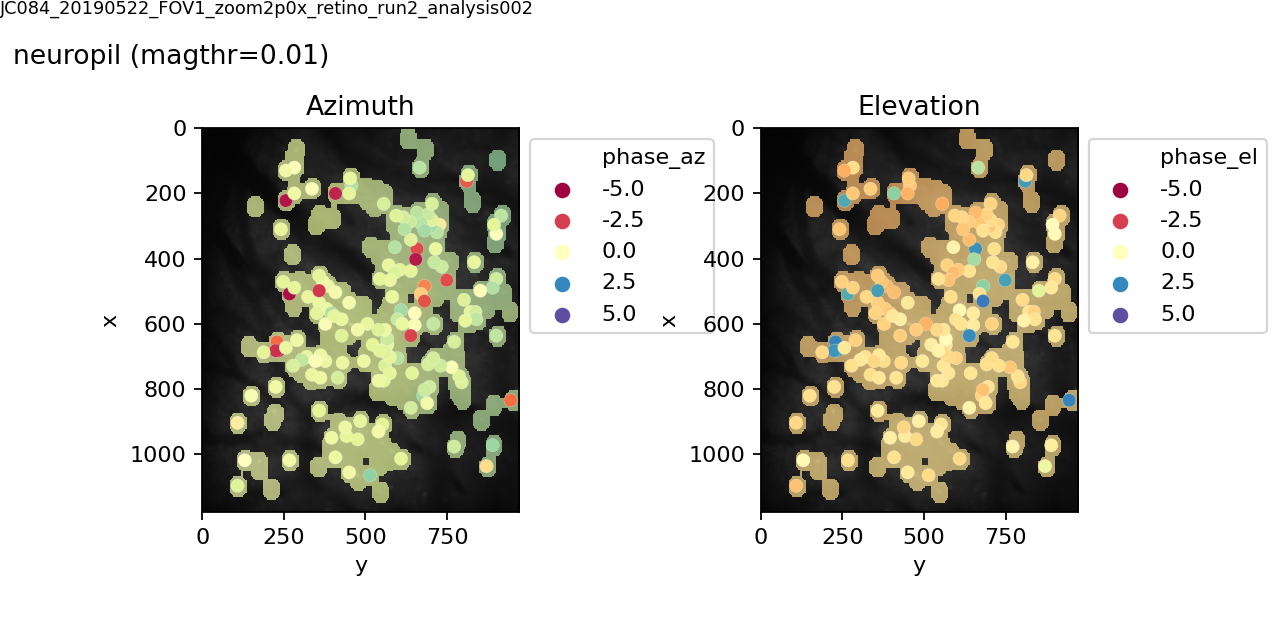

/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/retino_analysis/analysis002_7e9e1a/visualization sanitycheck_centroids_vs_neuropil_masks


In [284]:
cmap='Spectral' #pl.get_cmap('cmr.rainforest')
plot_neuropil=True
lw=0.1
np_alpha=0.7

mask_str='neuropil' if plot_neuropil else 'soma'
normalize = mpl.colors.Normalize(vmin=abs_vmin, vmax=abs_vmax)
# cmap = sns.color_palette('nipy_spectral')

fig, axn = pl.subplots(1, 2, figsize=(8,4))
ax = axn[0]
ax.imshow(zimg_r, cmap='gray') #, vmin=abs_vmin, vmax=abs_vmax)
if plot_neuropil:
    ax.imshow(azim_phase_np_r, cmap=cmap, vmin=abs_vmin, vmax=abs_vmax, alpha=np_alpha)
else:
    ax.imshow(azim_phase_soma_r, cmap=cmap, vmin=abs_vmin, vmax=abs_vmax, alpha=alpnp_alphaha)
sns.scatterplot(x='y', y='x', data=retinodf.loc[pass_mag_rois], 
                hue='phase_az', ax=ax, palette=cmap, alpha=1, hue_norm=normalize,
                linewidth=lw, edgecolors='k')
ax.set_title("Azimuth")
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

ax = axn[1]
ax.imshow(zimg_r, cmap='gray') #, vmin=abs_vmin, vmax=abs_vmax)
if plot_neuropil:
    ax.imshow(elev_phase_np_r, cmap=cmap, vmin=abs_vmin, vmax=abs_vmax, alpha=np_alpha)
else:
    ax.imshow(elev_phase_soma_r, cmap=cmap, vmin=abs_vmin, vmax=abs_vmax, alpha=np_alpha)
sns.scatterplot(x='y', y='x', data=retinodf.loc[pass_mag_rois], 
                hue='phase_el', ax=ax, palette=cmap, alpha=1, hue_norm=normalize,
                linewidth=lw, edgecolors='k')
ax.set_title("Elevation")
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')

pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)
fig.text(0.01, 0.9, '%s (magthr=%.2f)' % (mask_str, magthr_2p), fontsize=12)

label_figure(fig, data_id)
figname = 'sanitycheck_centroids_vs_%s_masks' % mask_str
pl.savefig(os.path.join(animal_dst_dir, '%s.svg' % figname)) 

print(animal_dst_dir, figname)

In [285]:
len(roi_list)

191

In [286]:
del masks_soma
del dilated_masks
del masks_r


In [353]:
screen2p_y

67.323

In [341]:
screen2p_x = 119.5564
screen2p_y = 67.323
resolution2p = [1920, 1080] #[1024, 768]

lmax_az_2p = screen2p_x #/2.
lmin_az_2p = 0 #-screen2p_x #-lmax_az_2p
lmax_el_2p = screen2p_y #/2.
lmin_el_2p = 0 #-screen2p_y# 0 #-lmax_el_2p

# lmax_az_2p = screen2p_x/2.
# lmin_az_2p = -lmax_az_2p
# lmax_el_2p = screen2p_y/2.
# lmin_el_2p = -lmax_el_2p

In [371]:
smooth_fwhm = 91 #21
#azim_smoothed = smooth_array(azim_smoothed, smooth_fwhm, phaseArray=True)
azim_smoothed = smooth_neuropil(azim_phase_np_r, smooth_fwhm=smooth_fwhm)
elev_smoothed = smooth_neuropil(elev_phase_np_r, smooth_fwhm=smooth_fwhm)

azi_2p_np = convert_range(azim_smoothed, newmin=lmin_az_2p, newmax=lmax_az_2p,
                          oldmin=abs_vmin, oldmax=abs_vmax)
el_2p_np = convert_range(elev_smoothed, newmin=lmin_az_2p, newmax=lmax_az_2p, 
                         oldmin=abs_vmin, oldmax=abs_vmax)

In [372]:
retinodf['az_lin'] = convert_range(retinodf['phase_az'], newmin=lmin_az_2p, newmax=lmax_az_2p, 
                                   oldmin=abs_vmin, oldmax=abs_vmax)
retinodf['el_lin'] = convert_range(retinodf['phase_el'], newmin=lmin_az_2p, newmax=lmax_az_2p, 
                                   oldmin=abs_vmin, oldmax=abs_vmax)

In [373]:
roi_retino_file = '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/retino_analysis/retino_analysis.pkl'

R = {'azi_np': azi_2p_np, 'el_np': el_2p_np, 'retinodf': retinodf,
    'lmin_az': lmin_az_2p, 'lmax_az': lmax_az_2p,
    'lmin_el': lmin_el_2p, 'lmax_el': lmax_el_2p}

with open(roi_retino_file, 'wb') as f:
    pkl.dump(R, f, protocol=2)

<IPython.core.display.Javascript object>


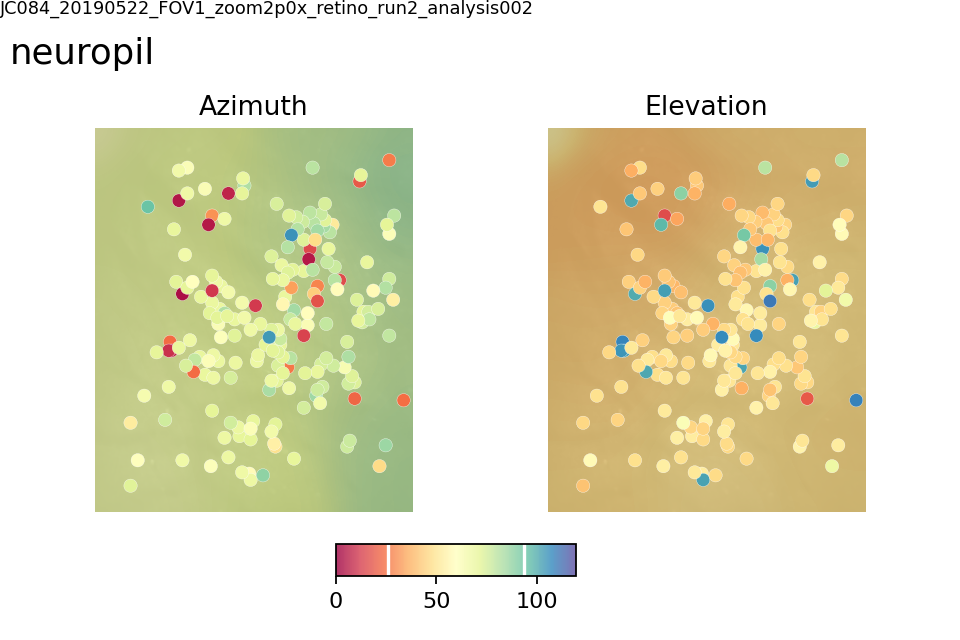

/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/retino_analysis/analysis002_7e9e1a/visualization smoothed_np_retino_with_centroids_LIN


In [379]:
vmin = lmin_az_2p
vmax = lmax_az_2p
np_alpha=0.8
lw=0.15
normalize = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

fig, axn = pl.subplots(1, 2, figsize=(6,4))
ax = axn[0]
ax.imshow(zimg_r, cmap='gray') #, vmin=abs_vmin, vmax=abs_vmax)
ax.imshow(azi_2p_np, cmap=cmap, vmin=vmin, vmax=vmax, alpha=np_alpha)
sns.scatterplot(x='y', y='x', data=retinodf.loc[roi_list], 
                hue='az_lin', ax=ax, palette=cmap, alpha=1, hue_norm=normalize,
                linewidth=lw, edgecolors='k')
ax.set_title("Azimuth")
ax.legend_.remove()

ax = axn[1]
ax.imshow(zimg_r, cmap='gray') #, vmin=abs_vmin, vmax=abs_vmax)
im = ax.imshow(el_2p_np, cmap=cmap, vmin=vmin, vmax=vmax, alpha=np_alpha)
sns.scatterplot(x='y', y='x', data=retinodf.loc[roi_list], 
                hue='el_lin', ax=ax, palette=cmap, alpha=1, hue_norm=normalize,
                linewidth=lw, edgecolors='k')
ax.set_title("Elevation")
ax.legend_.remove()

pl.subplots_adjust(left=0.05, right=0.95, bottom=0.2, top=0.8, wspace=0.1)
fig.text(0.01, 0.9, mask_str, fontsize=16)

cb = fig.add_axes([0.35, 0.1, 0.25, 0.05])
pl.colorbar(im, cax=cb, orientation='horizontal')
ab_max_az = max([abs(lmax_az_2p), abs(lmin_az_2p)])
ab_max_el = max([abs(lmin_el_2p), abs(lmax_el_2p)])
screen_lim_pos = ab_max_el/ab_max_az #(lmax_alt-screen_h_max)/(lmax_alt*2.)
if abs(round(lmin_az_2p))==abs(round(lmax_az_2p)):#<0: # Center is 0
    cb.axvline(x=screen_lim_pos*lmax_az_2p, color='w') # my data is between 0 and 1
    cb.axvline(x=screen_lim_pos*lmin_az_2p, color='w') # my data is between 0 and 1
else: # min=0, max=120
    c_min, cmax = cb.get_xlim()
    screen_midp = (ab_max_az/2.)
    cb.axvline(x=screen_midp+(screen_lim_pos*ab_max_az)/2., color='w') # my data is between 0 and 1
    cb.axvline(x=screen_midp-(screen_lim_pos*ab_max_az)/2., color='w') # my data is between 0 and 1
#cb.axvline(x=0, color='w')

for ax in axn.flat:
    ax.axis('off')
label_figure(fig, data_id)
figname = 'smoothed_np_retino_with_centroids_LIN'
pl.savefig(os.path.join(animal_dst_dir, '%s.svg' % figname)) 

print(animal_dst_dir, figname)

In [375]:
(screen_lim_pos*ab_max_az)/2

33.6615

In [376]:
ab_max_el

67.323

In [377]:
ab_max_el/ab_max_az

0.5631066174625532

<IPython.core.display.Javascript object>


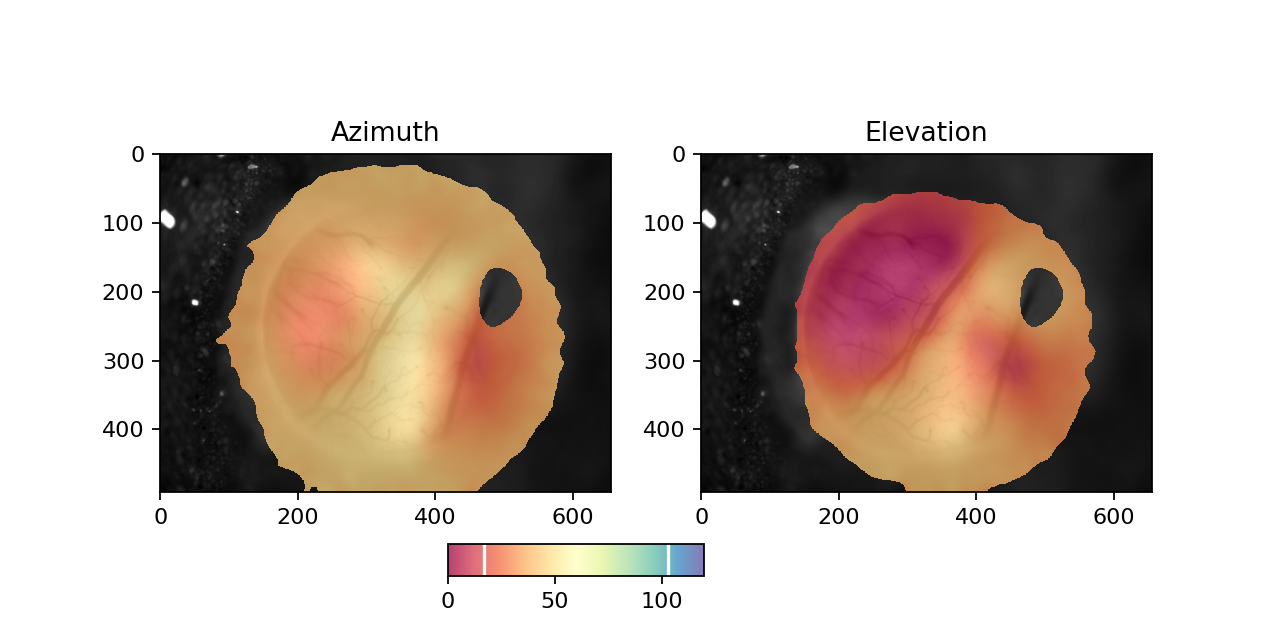

In [378]:
fig, axn = pl.subplots(1,2, figsize=(8,4))
ax=axn[0]
ax.set_title('Azimuth')
ax.imshow(surface_hd, cmap='gray')
im = ax.imshow(az_wf, cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.75)
#pl.colorbar(im, orientation='horizontal', shrink=0.8)

ax=axn[1]
ax.set_title('Elevation')
ax.imshow(surface_hd, cmap='gray')
im1 = ax.imshow(el_wf, cmap=cmap, vmin=vmin, vmax=vmax, alpha=0.75)

cb = fig.add_axes([0.35, 0.1, 0.2, 0.05])
pl.colorbar(im, cax=cb, orientation='horizontal')

screen_lim_pos = screen_h_max/lmax_alt #(lmax_alt-screen_h_max)/(lmax_alt*2.)
if lmin_az_2p<0: # Center is 0
    cb.axvline(x=screen_lim_pos*lmax_alt, color='w') # my data is between 0 and 1
    cb.axvline(x=screen_lim_pos*lmin_alt, color='w') # my data is between 0 and 1
else: # min=0, max=120
    c_min, c_max = cb.get_xlim()
    cb.axvline(x=c_min+(screen_lim_pos*lmax_alt)/2., color='w') # my data is between 0 and 1
    cb.axvline(x=c_max-(screen_lim_pos*lmax_alt)/2., color='w') # my data is between 0 and 1
#cb.axvline(x=0, color='w')

<IPython.core.display.Javascript object>


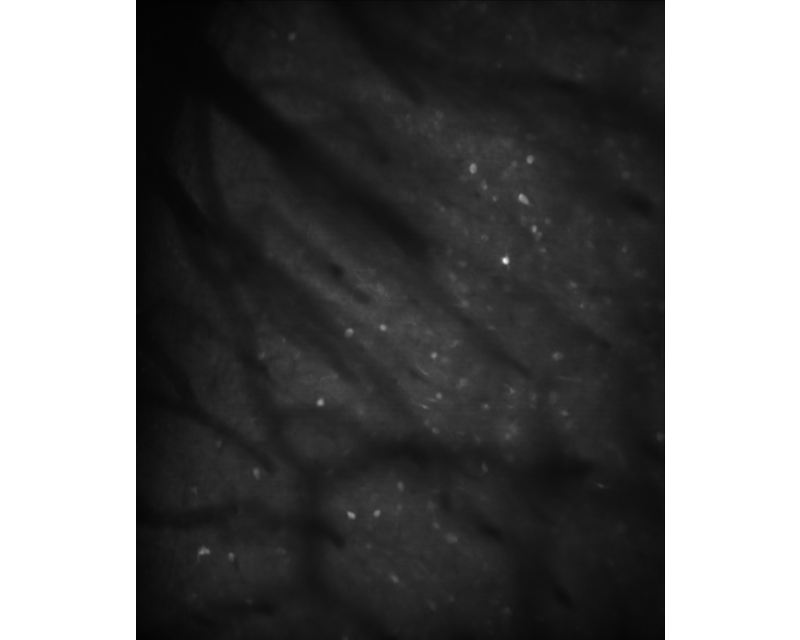

In [850]:

fig = pl.figure(figsize=(5,4), frameon=False)
ax = pl.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(zimg_r, cmap='gray') #, 

figname = '2pfov'
pl.savefig(os.path.join(aggregate_results_dir, '%s_%s_%s.pdf' \
                        % (animalid, session_2p, figname)))

# Plot example traces 

In [67]:
animal_dst_dir

'/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_670ea2/visualization'

In [68]:
curr_dst_dir = os.path.join(animal_dst_dir, 'example_traces')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_670ea2/visualization/example_traces


In [69]:
def plot_example_traces(soma_traces, np_traces, rid=0, cond='right',
                       soma_color='k', np_color='r', ax=None):
    
    if ax is None:
        fig, ax = pl.subplots()
    ax.plot(soma_traces[cond][rid], soma_color, label='soma')
    ax.plot(np_traces[cond][rid], np_color, label='neuropil')
    
    return ax

In [70]:
animalid, session, fov, retinorun_2p

('JC084', '20190517', 'FOV1_zoom2p0x', 'retino_run1')

In [71]:
# soma_traces = rutils.load_traces(animalid, session, fov, run=retinorun,
#                                   analysisid=retinoid, trace_type='raw')

soma_traces = load_roi_traces(animalid, session_2p, fov, run=retinorun_2p,
                 analysisid=retinoid, trace_type='corrected', detrend_after_average=True)

# Do fft

... loading traces (corrected)
... loading traces from: /n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_670ea2


In [72]:
### Convert raw/processed traces to df/f
dff_soma = dict((cond, (tdf - tdf.mean(axis=0))/ tdf.mean(axis=0)) for cond, tdf in soma_traces.items())
#dff_np = dict((cond, (tdf - tdf.mean(axis=0))/ tdf.mean(axis=0)) for cond, tdf in np_traces.items())


In [73]:
# Get average across conditions
mean_phase_values_soma = phases_soma.mean(axis=1).values 

mean_magratio_values_soma = magratios_soma.mean(axis=1).values 
mean_magratio_values_np = magratios_np.mean(axis=1).values

# Sort ROIs by their average mag ratios
sorted_rois_soma = np.argsort(mean_magratio_values_soma)[::-1]
for roi in sorted_rois_soma[0:10]:
    print(roi, mean_magratio_values_soma[roi].round(3), mean_phase_values_soma[roi].round(3))

155 0.038 -0.161
48 0.034 -1.112
222 0.029 2.039
75 0.029 -0.744
67 0.029 0.729
17 0.028 2.454
89 0.027 -0.981
178 0.027 -0.534
14 0.027 1.946
141 0.026 -1.062


In [74]:
cycle_start_ixs = scaninfo['stimulus']['cycle_start_ixs']

In [76]:
    #n_cycles = int(round((n_frames/fr) / stimperiod))
    #n_frames_per_cycle = int(np.floor(stimperiod * fr))
    #cycle_starts = np.round(np.arange(0, n_frames_per_cycle * n_cycles, n_frames_per_cycle)).astype('int')

    n_frames = scaninfo['stimulus']['n_frames']
    fr = scaninfo['stimulus']['frame_rate']
    stimfreq= scaninfo['stimulus']['stim_freq']
    
    # Get frequency info
    freqs = np.fft.fftfreq(n_frames, float(1./fr))
    sorted_idxs = np.argsort(freqs)
    freqs = freqs[sorted_idxs] # sorted
    freqs = freqs[int(np.round(n_frames/2.))+1:] # exclude DC offset from data
    stim_freq_idx = np.argmin(np.absolute(freqs - stimfreq)) # Index of stimulation frequency

# get phase and magnitude
#     mag_data = abs(fft_results)
#     phase_data = np.angle(fft_results)

#     # sort mag and phase by freq idx:
#     mag_data = mag_data[sorted_idxs]
#     phase_data = phase_data[sorted_idxs]

In [77]:
dff_soma['right']

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,259
0,-0.133299,-0.010842,0.095980,0.322191,-0.024589,-0.054382,0.017868,-0.028247,-0.041393,0.042884,...,0.005675,-0.067252,0.000216,0.055244,-0.015129,-0.036244,-0.007701,0.019082,0.023167,0.044385
1,0.108996,0.035121,-0.037225,0.325913,-0.026256,-0.076572,-0.020247,0.001896,-0.011939,0.031696,...,-0.023762,-0.015434,0.005613,0.021468,-0.038165,-0.013654,-0.016632,0.049906,-0.021121,-0.017154
2,0.194340,0.018926,-0.096685,0.190209,0.013481,-0.092475,-0.017136,-0.024296,0.043793,0.008681,...,-0.019512,0.067898,-0.010958,-0.044837,-0.040472,0.024642,0.006852,0.077150,-0.055891,-0.068325
3,0.043831,-0.032363,0.050300,0.084376,-0.022552,0.004346,0.053890,0.061606,0.099547,0.040751,...,-0.016545,0.072189,0.008538,-0.072148,-0.025532,0.045243,0.040904,0.042730,-0.029556,-0.013771
4,0.035061,-0.021895,0.081915,0.144443,-0.043644,-0.004896,-0.005284,0.170472,0.093780,0.067156,...,-0.006805,0.057831,0.017967,-0.084556,-0.038163,0.033646,0.042580,0.049660,0.005500,0.009264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4117,-0.081527,-0.059718,-0.024751,-0.001117,0.034554,-0.073539,0.034886,0.051806,-0.046967,-0.066246,...,-0.074799,-0.038181,0.069215,-0.020528,0.054060,0.004450,0.044244,0.025329,-0.014265,-0.026577
4118,-0.096042,-0.020511,-0.092174,0.050723,0.010028,-0.086733,-0.007218,0.022932,-0.020361,-0.030579,...,-0.084228,-0.081068,0.069732,-0.002851,0.033485,-0.048464,-0.009190,0.032399,-0.019076,-0.047180
4119,-0.067446,-0.038417,-0.089866,0.034893,0.049872,-0.050555,0.041610,0.017520,-0.022605,-0.036067,...,-0.023329,-0.071806,0.072445,-0.001122,0.020171,-0.018125,-0.021919,-0.002395,0.027268,-0.086800
4120,-0.029151,-0.034180,-0.050310,0.055923,0.069372,-0.089503,0.054279,0.073688,-0.070694,-0.044822,...,-0.033194,-0.004084,0.053728,-0.013795,0.032481,-0.000272,-0.005577,0.017059,0.087236,-0.073242


In [78]:

def do_fft_return_arrray(avg_traces, sorted_idxs, stim_freq_idx):
    n_frames = avg_traces.shape[0]

    fft_results = np.fft.fft(avg_traces, axis=0) #avg_traces.apply(np.fft.fft, axis=1)

    # get phase and magnitude
    mag_data = abs(fft_results) #**2
    phase_data = np.angle(fft_results)

    # sort mag and phase by freq idx:
    mag_data = mag_data[sorted_idxs]
    phase_data = phase_data[sorted_idxs]

    # exclude DC offset from data
    #if len(mag_data.shape)==1:
    print("excl offset")
    mag_data = mag_data[int(np.round(n_frames/2.))+1:]
    phase_data = phase_data[int(np.round(n_frames/2.))+1:]
    
    return pd.DataFrame(mag_data), pd.DataFrame(phase_data)

In [79]:
marray, parray = do_fft_return_arrray(dff_soma['right'], sorted_idxs, stim_freq_idx)


excl offset


<IPython.core.display.Javascript object>


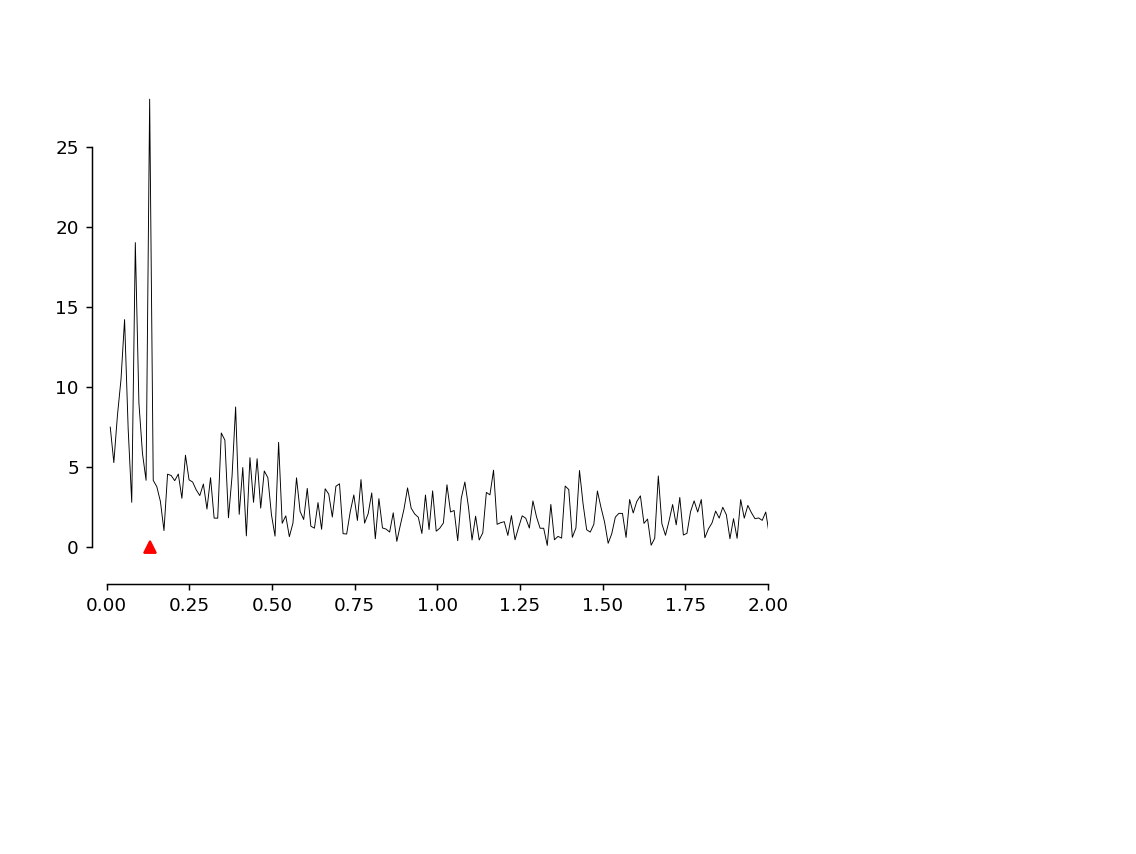

0.12999359534206695 0.12999359534206695


In [81]:
rid = 155
fig, ax = pl.subplots()

max_idx = marray[rid].argmax()
print(freqs[max_idx], freqs[stim_freq_idx])
label='Cell %i, max=%.2f Hz' % (rid, freqs[max_idx])
ax.plot(freqs, marray[rid], color='k', lw=0.5, label=label)
ax.plot(freqs[stim_freq_idx], 0, 'r^')
ax.set_xlim([0, 2])
sns.despine(trim=True, offset=8)

In [82]:
np.array(scaninfo['frame_nums']).astype(float)


array([1.000e+00, 2.000e+00, 3.000e+00, ..., 4.120e+03, 4.121e+03,
       4.122e+03])

In [79]:
import matplotlib.gridspec as gridspec
# Plotting
def label_figure(fig, data_identifier):
    fig.text(0, 1,data_identifier, ha='left', va='top', fontsize=8)

    

In [80]:
sorted_rois_soma[0:5]

NameError: name 'sorted_rois_soma' is not defined

<IPython.core.display.Javascript object>


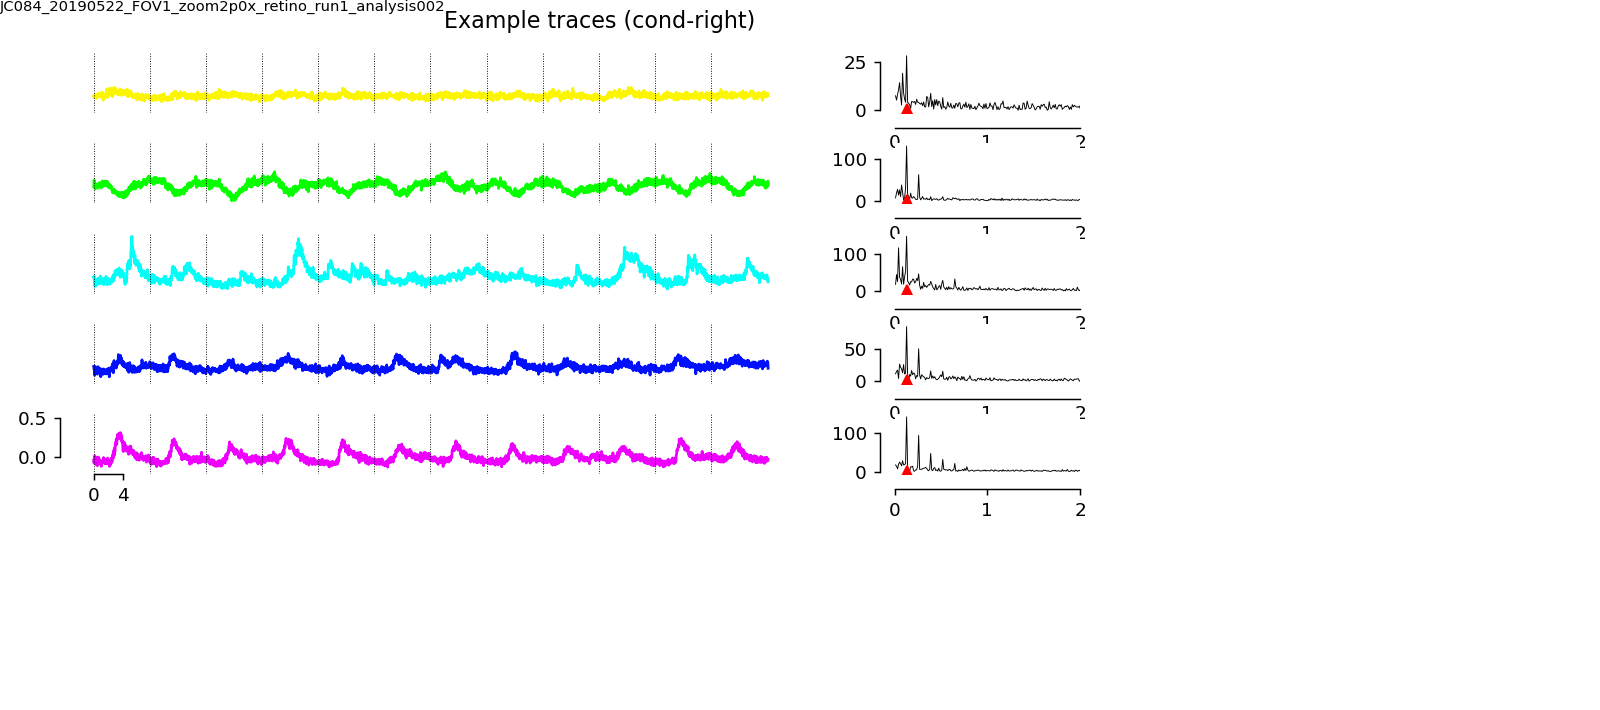

[]
[<AxesSubplot:>, <AxesSubplot:>]
[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]
[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]
[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]


In [85]:
#plot_rois = [57, 355, 247] #, 346] #, id = sorted_rois_soma[0] #113
plot_rois = sorted_rois_soma[0:5]

roi_colors = sns.color_palette(cmap, n_colors=len(plot_rois))
save_plot = True

cond='right'
time_sec = np.array(scaninfo['frame_nums']).astype(float) * (1./fr)
#fig, axn = pl.subplots(4, 1, sharex=True, sharey=True, figsize=(5, 6))

fig = pl.figure(figsize=(9,4))
gs = gridspec.GridSpec(len(plot_rois), 4) # sharex=True, sharey=True)


for ai, (col, rid) in enumerate(zip( roi_colors, plot_rois)):
    print(fig.axes)
    if ai==0:
        ax=fig.add_subplot(gs[ai, 0:3])
    else:
        ax=fig.add_subplot(gs[ai, 0:3], sharex=fig.axes[0], sharey=fig.axes[0])
    ax.plot(time_sec, dff_soma[cond][rid], color=col, label='soma')
    for cyc in cycle_start_ixs:
        ax.axvline(x=time_sec[cyc], linestyle=':', linewidth=0.5, color='k')
    if ai!=(len(plot_rois)-1):
        ax.axis('off')
    else:
        ax.set_xticks([0, 4])

    if ai==0:
        ax=fig.add_subplot(gs[ai, 3:])
    else:
        ax=fig.add_subplot(gs[ai, 3:], sharex=fig.axes[1]) #, sharey=fig.axes[1])
    max_idx = marray[rid].argmax()
    #print(freqs[max_idx], freqs[stim_freq_idx])
    label='Cell %i, max=%.2f Hz' % (rid, freqs[max_idx])
    ax.plot(freqs, marray[rid], color='k', lw=0.5, label=label)
    ax.plot(freqs[stim_freq_idx], 0, 'r^')
    ax.set_xlim([0, 2])
    sns.despine(trim=True, offset=8, ax=ax)
    if ai!=(len(plot_rois)-1):
        ax.tick_params(which='both', axis='x', size=0) #off')
        #ax.set_xticks([])

    
pl.subplots_adjust(left=0.05, right=0.9, hspace=0.5, top=0.9, wspace=0.5)
sns.despine(trim=True)

pl.suptitle('Example traces (cond-%s)' % cond)
label_figure(fig, data_id)


pl.savefig(os.path.join(curr_dst_dir, 'dff_traces_with_magspec.svg'))

In [247]:
time_sec

50.008062204385844

# CaImAn extracted traces

In [93]:
import pickle as pkl

In [94]:
roi_retino_file = '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/retino_analysis/retino_analysis.pkl'

with open(roi_retino_file, 'rb') as f:
    roiret = pkl.load(f)
roiret.keys()

dict_keys(['azi_np', 'el_np', 'retinodf'])

In [95]:
azi_2p_np = roiret['azi_np']
el_2p_np = roiret['el_np']


In [777]:
caiman_results_dir = '/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/caiman_results'
caiman_retino_file = os.path.join(caiman_results_dir, 'retino_analysis.pkl')

with open(caiman_retino_file, 'rb') as f:
    caiman = pkl.load(f)
caiman.keys()

dict_keys(['traces', 'dff_traces', 'magratios', 'phases', 'masks'])

In [721]:
caiman['masks'].shape
masks_cm = caiman['masks'].copy()
magratios_cm = caiman['magratios'].copy()
phases_cm = caiman['phases'].copy()

<IPython.core.display.Javascript object>


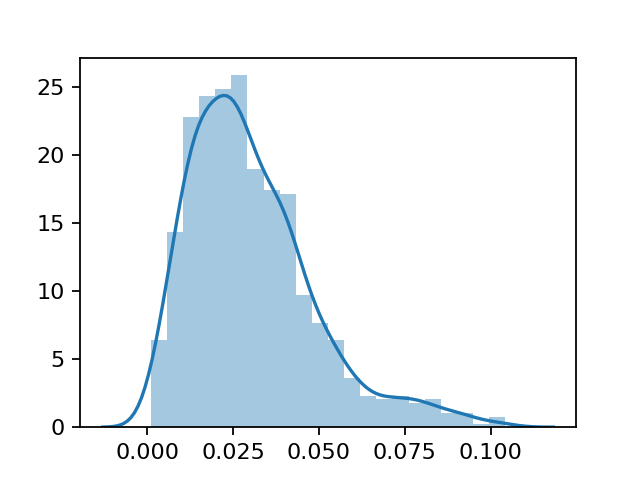

<AxesSubplot:>

In [722]:
pl.figure(figsize=(4,3))
sns.distplot(magratios_cm.values.ravel())

In [725]:
print(lmin_az_2p,lmax_az_2p)

0 119.5564


In [726]:
magratios_cm.head()

,top,right,left,bottom
0,0.018599,0.044401,0.057904,0.043133
1,0.011950,0.048199,0.053802,0.005852
2,0.023249,0.021369,0.032923,0.039585
3,0.022103,0.023061,0.021712,0.025529
4,0.013062,0.019189,0.017699,0.005421


In [727]:
phases_soma.max()

top       3.097671
bottom    3.141589
left      3.075773
right     3.138163
dtype: float64

In [728]:
df_cm.head()

,phase_az,phase_el,mag_az,mag_el,az_lin,el_lin
0,1.443499,-0.110782,0.051153,0.030866,87.245094,57.670235
1,2.076685,-1.201524,0.051001,0.008901,99.293355,36.915603
2,NaN,NaN,0.027146,0.031417,NaN,NaN
3,NaN,NaN,0.022386,0.023816,NaN,NaN
4,-0.434587,-0.754272,0.018444,0.009242,51.508887,45.425919


In [729]:
# Combine conds to get absolute maps
trials_by_cond=None
use_pixels=False
ds_factor=2
abs_vmin = -np.pi
abs_vmax=np.pi

# d1_orig=512
# d2_orig=512
magthr_2p = 0.01
delay_map_thr=1.5
df_cm = get_final_maps(magratios_cm, phases_cm, trials_by_cond=None,
                    mag_thr=magthr_2p, dims=(d1_orig, d2_orig), 
                       ds_factor=ds_factor, use_pixels=use_pixels)
print(df_cm.shape)

df_cm['az_lin'] = convert_range(df_cm['phase_az'], newmin=lmin_az_2p, newmax=lmax_az_2p, 
                                   oldmin=abs_vmin, oldmax=abs_vmax)

df_cm['el_lin'] = convert_range(df_cm['phase_el'], newmin=lmin_az_2p, newmax=lmax_az_2p, 
                                   oldmin=abs_vmin, oldmax=abs_vmax)

got phase: 0.0031100160907883154 6.2676568461620406
got absolute: -2.89395610524568 3.06223009063191
Delay: 0.25837490556725107 6.192169297158616
Total: 208
 After mag_thr (0.010): 208
 After delay_thr (1.500): 151
(208, 4)


In [730]:
# Get pixel size
ncomp, d1_cm, d2_cm = masks_cm.shape

ds_cm = d1_orig/float(d1_cm)
pixel_size = get_pixel_size()
pixel_size_ds = (pixel_size[0]*ds_cm, pixel_size[1]*ds_cm)
d1_cm = int(d1_cm/ds_cm)
d2_cm = int(d2_cm/ds_cm)
print(d1_cm, d2_cm)

512 512


In [731]:
pixel_size_ds

(2.3, 1.9)

In [732]:
# Reshape and transform maps for visualization
nrois_total = masks_cm.shape[0]
masks_r0 = np.dstack([transform_2p_fov(masks_cm[i, :], pixel_size_ds, normalize=False) \
                     for i in range(nrois_total)]).T
masks_r_cm = np.swapaxes(masks_r0, 1, 2) # [nrois, d1/rows/y, d2/cols]
print(masks_r_cm.shape)

(208, 1177, 972)


<IPython.core.display.Javascript object>


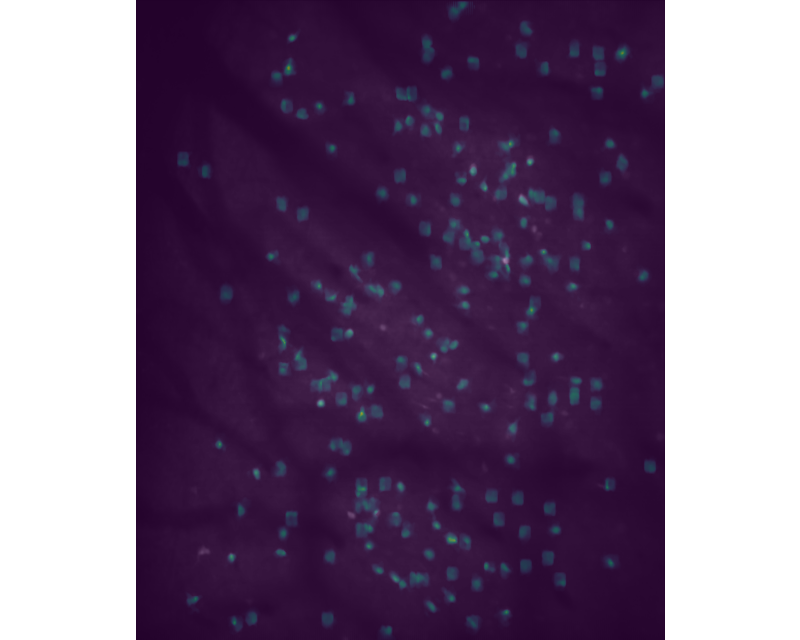

In [733]:

fig = pl.figure(figsize=(5,4), frameon=False)
ax = pl.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

ax.imshow(zimg_r, cmap='gray')
ax.imshow(masks_r_cm.sum(axis=0), alpha=0.5)

# fig = pl.figure(figsize=(5,4), frameon=False)
# ax = pl.Axes(fig, [0., 0., 1., 1.])
# ax.set_axis_off()
# fig.add_axes(ax)
# im = ax.imshow(surface_hd, cmap='gray', interpolation='nearest')


In [734]:
magratios_cm

,top,right,left,bottom
0,0.018599,0.044401,0.057904,0.043133
1,0.011950,0.048199,0.053802,0.005852
2,0.023249,0.021369,0.032923,0.039585
3,0.022103,0.023061,0.021712,0.025529
4,0.013062,0.019189,0.017699,0.005421
...,...,...,...,...
203,0.018811,0.012095,0.008399,0.026636
204,0.015698,0.046346,0.011570,0.002312
205,0.028132,0.043734,0.029000,0.021221
206,0.053847,0.083426,0.079973,0.087089


In [756]:
# Get centroids of ROI masks for visualization
centroids_cm = get_roi_centroids(masks_r_cm)
retinodf_cm = pd.concat([centroids_cm, df_cm], axis=1)
retinodf_cm.head()

,x,y,phase_az,phase_el,mag_az,mag_el,az_lin,el_lin
0,855.0,946.0,1.443499,-0.110782,0.051153,0.030866,87.245094,57.670235
1,155.0,956.0,2.076685,-1.201524,0.051001,0.008901,99.293355,36.915603
2,301.0,893.0,NaN,NaN,0.027146,0.031417,NaN,NaN
3,106.0,890.0,NaN,NaN,0.022386,0.023816,NaN,NaN
4,93.0,896.0,-0.434587,-0.754272,0.018444,0.009242,51.508887,45.425919


In [757]:
# import sys
# !{sys.executable} -m pip install jupyterthemes

In [758]:
retinodf_cm.shape, retinodf_cm[retinodf_cm.mag_az>=magthr_2p].shape

((208, 8), (92, 8))

In [759]:
magthr_2p=0.03

pass_rois_cm = retinodf_cm[retinodf_cm.mag_az>=magthr_2p].dropna().index.tolist()
print("%i of %i cells pass mag thr (%.2f)" % (len(pass_rois_cm), len(retinodf_cm), magthr_2p))

76 of 208 cells pass mag thr (0.03)


In [760]:
curr_vmin = np.min([retinodf_cm.loc[pass_rois_cm][['az_lin', 'el_lin']].min()])
curr_vmax = np.max([retinodf_cm.loc[pass_rois_cm][['az_lin', 'el_lin']].max()])
print(curr_vmin, curr_vmax)

14.715649970493248 111.86210196208395


In [761]:

colormap = 'batlow' #'nic_Edge'
cmapdir = '/n/coxfs01/julianarhee/colormaps' #os.path.join(aggr_dir, 'colormaps')
cdata = np.loadtxt(os.path.join(cmapdir, colormap) + ".txt")
cmap_phase = LinearSegmentedColormap.from_list('my_colormap', cdata[::-1])


<IPython.core.display.Javascript object>


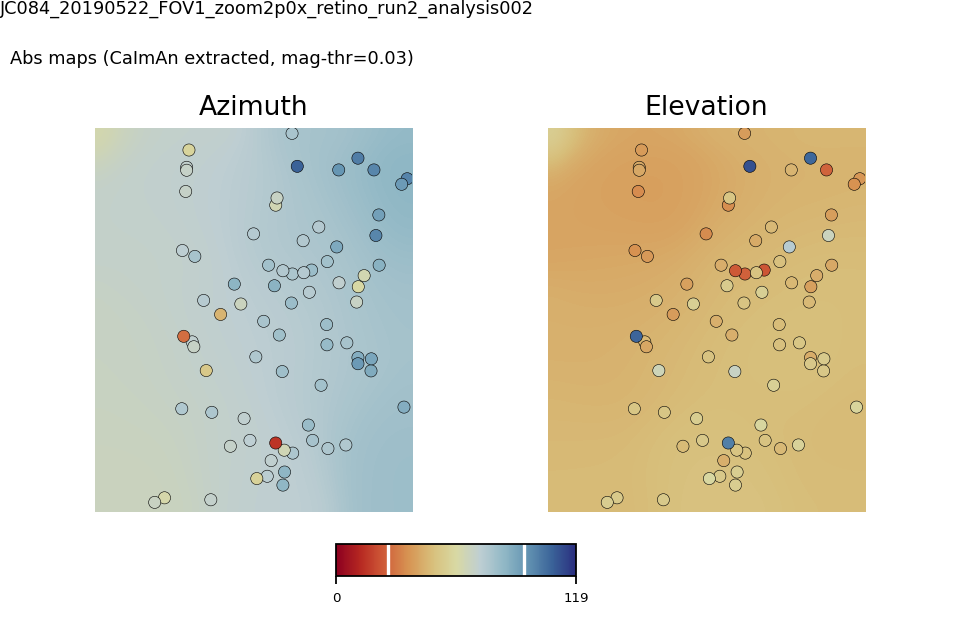

/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/caiman_results smoothed_np_retino_with_centroids_LIN


In [849]:
# vmin = curr_vmin#lmin_az_2p
# vmax = curr_vmax #lmax_az_2p
vmin = lmin_az_2p
vmax = lmax_az_2p
cmap=dark_spectral#'RdYlBu' #cmap_phase #'Spectral'#'twilight' #pl.get_cmap('cmr.guppy')
lw=0.25
alpha=1
markersize=30

normalize = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

fig, axn = pl.subplots(1, 2, figsize=(6,4))
ax = axn[0]
ax.imshow(zimg_r, cmap='gray') #, vmin=abs_vmin, vmax=abs_vmax)
ax.imshow(azi_2p_np, cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha)
sns.scatterplot(x='y', y='x', data=retinodf_cm.loc[pass_rois_cm], 
                hue='az_lin', ax=ax, palette=cmap, alpha=1, hue_norm=normalize,
                linewidth=lw, edgecolor='k', s=markersize)
ax.set_title("Azimuth")
ax.legend_.remove()

ax = axn[1]
ax.imshow(zimg_r, cmap='gray') #, vmin=abs_vmin, vmax=abs_vmax)
im = ax.imshow(el_2p_np, cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha)
sns.scatterplot(x='y', y='x', data=retinodf_cm.loc[pass_rois_cm], 
                hue='el_lin', ax=ax, palette=cmap, alpha=1, hue_norm=normalize,
                linewidth=lw, edgecolor='k', s=markersize)
ax.set_title("Elevation")
ax.legend_.remove()

pl.subplots_adjust(left=0.05, right=0.95, bottom=0.2, top=0.8, wspace=0.1)
fig.text(0.01, 0.9, 'Abs maps (CaImAn extracted, mag-thr=%.2f)' %magthr_2p, fontsize=8)

cb = fig.add_axes([0.35, 0.1, 0.25, 0.05])
cbar = pl.colorbar(im, cax=cb, orientation='horizontal', ticks=[vmin, vmax])
ab_max_az = max([abs(lmax_az_2p), abs(lmin_az_2p)])
ab_max_el = max([abs(lmin_el_2p), abs(lmax_el_2p)])
screen_lim_pos = ab_max_el/ab_max_az #(lmax_alt-screen_h_max)/(lmax_alt*2.)
if abs(round(lmin_az_2p))==abs(round(lmax_az_2p)):#<0: # Center is 0
    cb.axvline(x=screen_lim_pos*lmax_az_2p, color='w') # my data is between 0 and 1
    cb.axvline(x=screen_lim_pos*lmin_az_2p, color='w') # my data is between 0 and 1
else: # min=0, max=120
    c_min, cmax = cb.get_xlim()
    screen_midp = (ab_max_az/2.)
    cb.axvline(x=screen_midp+(screen_lim_pos*ab_max_az)/2., color='w') # my data is between 0 and 1
    cb.axvline(x=screen_midp-(screen_lim_pos*ab_max_az)/2., color='w') # my data is between 0 and 1
# cbar.ax.set_xticklabels([int(curr_vmax), int(curr_vmin)], fontsize=6)
cbar.ax.set_xticklabels([int(lmin_az_2p), int(lmax_az_2p)], fontsize=6)

for ax in axn.flat:
    ax.axis('off')

label_figure(fig, data_id)
figname = 'smoothed_np_retino_with_centroids_LIN'
pl.savefig(os.path.join(caiman_results_dir, '%s.pdf' % figname)) 

print(caiman_results_dir, figname)

pl.savefig(os.path.join(aggregate_results_dir, '%s_%s_%s.pdf' \
                        % (animalid, session_2p, figname)))

In [763]:
cbar.ax.get_xlim()

(0.0, 119.5564)

## Plot traces

In [743]:
import numpy as np
from matplotlib.colors import LinearSegmentedColormap as lsc

def cmap_map(function, cmap, name='colormap_mod', N=None, gamma=None):
    """
    Modify a colormap using `function` which must operate on 3-element
    arrays of [r, g, b] values.

    You may specify the number of colors, `N`, and the opacity, `gamma`,
    value of the returned colormap. These values default to the ones in
    the input `cmap`.

    You may also specify a `name` for the colormap, so that it can be
    loaded using pl.get_cmap(name).
    """
    if N is None:
        N = cmap.N
    if gamma is None:
        gamma = cmap._gamma
    cdict = cmap._segmentdata
#     # Cast the steps into lists:
#     step_dict = {key: map(lambda x: x[0], cdict[key]) for key in cdict}
#     print(step_dict)
#     # Now get the unique steps (first column of the arrays):
#     step_list = np.unique(sum(step_dict.values(), []))
    step_dict = dict((k, list(v)) for k, v in cdict.items())
    step_list = np.unique(sum(step_dict.values(), []))

    # 'y0', 'y1' are as defined in LinearSegmentedColormap docstring:
    y0 = cmap(step_list)[:, :3]
    y1 = y0.copy()[:, :3]
    # Go back to catch the discontinuities, and place them into y0, y1
    for iclr, key in enumerate(['red', 'green', 'blue']):
        for istp, step in enumerate(step_list):
            try:
                ind = step_dict[key].index(step)
            except ValueError:
                # This step is not in this color
                continue
            y0[istp, iclr] = cdict[key][ind][1]
            y1[istp, iclr] = cdict[key][ind][2]
    # Map the colors to their new values:
#     y0 = np.array(map(function, y0))
#     y1 = np.array(map(function, y1))
    y0 = function(y0)
    y1 = function(y1)
    # Build the new colormap (overwriting step_dict):
    for iclr, clr in enumerate(['red', 'green', 'blue']):
        step_dict[clr] = np.vstack((step_list, y0[:, iclr], y1[:, iclr])).T
    return lsc(name, step_dict, N=N, gamma=gamma)

def darken(x, ):
   return x * 0.85

dark_spectral = cmap_map(darken, pl.get_cmap('RdYlBu'))

In [744]:
dark_spectral = cmap_map(darken, pl.get_cmap('RdYlBu'))
cmap = dark_spectral #'Spectral' #dark_spectral

In [745]:
caiman['phases'][curr_cond].min()

-3.1343547812673807

In [764]:
magthr_2p = 0.03
pass_rois_cm = retinodf_cm[retinodf_cm.mag_az>=magthr_2p].dropna().index.tolist()
curr_cond='right'

sorted_by_az_mag = retinodf_cm.loc[pass_rois_cm].sort_values(by='mag_az', ascending=True).index.tolist()
sorted_by_az_lin = retinodf_cm.loc[pass_rois_cm].sort_values(by='az_lin', ascending=True).index.tolist()


In [765]:
phase_array = caiman['phases'][curr_cond].copy()
phase_array_cont =  -1 * phase_array
phase_array_cont = phase_array_cont % (2*np.pi)

sorted_by_cond_mag = phase_array_cont.loc[pass_rois_cm]\
                            .sort_values(ascending=True).index.tolist()

In [766]:
print(phase_array_cont.min(), phase_array_cont.max())
print(phase_array.min(), phase_array.max())
print(curr_cond)

0.039654524653239494 6.250144332772475
-3.1343547812673807 3.1168565181697137
right


In [767]:
cycle_start_ixs = scaninfo['stimulus']['cycle_start_ixs']
cycle_start_ixs

array([   0,  186,  372,  558,  744,  930, 1116, 1302, 1488, 1674, 1860,
       2046])

In [768]:
fr = scaninfo['stimulus']['frame_rate']
cycle_start_secs = [i/fr for i in cycle_start_ixs]

In [769]:
2233/44.65

50.01119820828668

In [784]:
def zscore_dataframe(xdf):
    #rlist = [r for r in xdf.columns if isnumber(r)]
    z_xdf = (xdf-xdf.mean()).divide(xdf.std())
    return z_xdf

In [793]:
dff_traces = zscore_dataframe(pd.DataFrame(caiman['traces'][curr_cond]))


In [833]:
use_denoised=True
zscore=True
if use_denoised:
    if zscore:
        currt = zscore_dataframe(pd.DataFrame(caiman['traces'][curr_cond]))
    else:
        currt = caiman['traces'][curr_cond].copy()
else:
    # zscore
    if zscore: 
        currt= zscore_dataframe(pd.DataFrame(caiman['dff_traces'][curr_cond]))
        

scaled cmap lim: (0.0, 6.283185307179586)


<IPython.core.display.Javascript object>


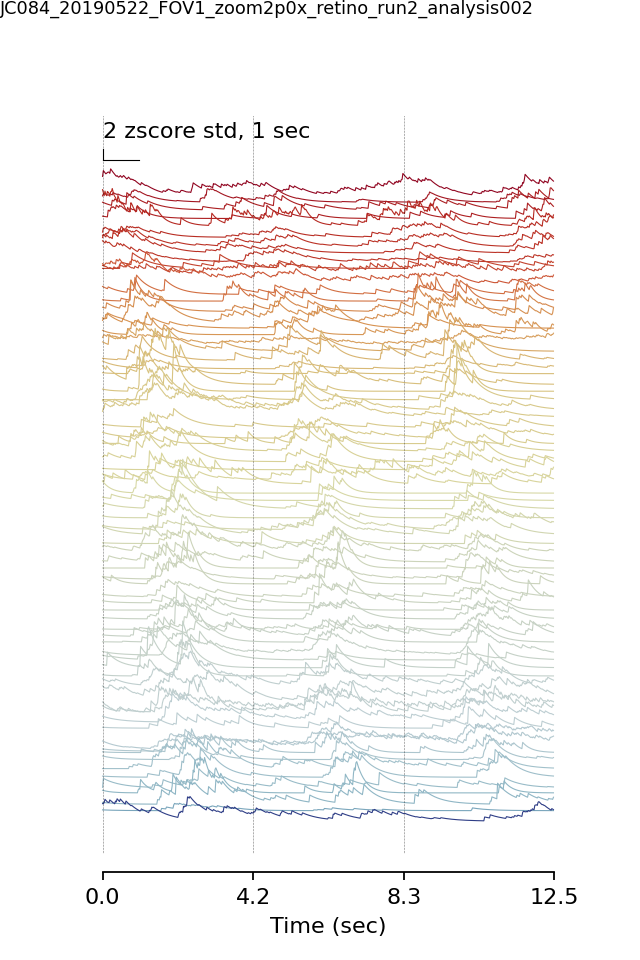

/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/caiman_results traces_waterfall_3cyc


In [848]:
n_cycles_plot = 3
n_frames_plot = scaninfo['stimulus']['n_frames_per_cycle']*n_cycles_plot

sorted_list = sorted_by_cond_mag[0::].copy()
offset=-1.5 if zscore else -150*2.
# offset=-0.005
lw=0.5
if zscore:
    yleg_pos=5
    y_scale=2.0
    leg_nsec=1.0
    x_scale=leg_nsec*fr

#hue_values = retinodf_cm.loc[sorted_list]['az_lin']
# vmin = lmin_az_2p#(lmin_az_2p/2.)
# vmax = lmax_az_2p#lmax_az_2p/2.

hue_values = phase_array_cont.loc[sorted_list]
vmin=0#-np.pi
vmax=2*np.pi

vmin = vmin if vmin is not None else hue_values[sorted_list].min()
vmax = vmax if vmax is not None else hue_values[sorted_list].max()

cnorm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
scalarmap = mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap)
print("scaled cmap lim:", scalarmap.get_clim())
    
fig, ax = pl.subplots(figsize=(4,6))
last_y = 0
for ri,rid in enumerate(sorted_list):
    if ri==0:
        #ax.plot([0, 20], [20, 20], 'r')
        ax.plot([0, x_scale], [yleg_pos, yleg_pos], color='k', lw=lw)
        ax.plot([0, 0], [yleg_pos, yleg_pos+y_scale], color='k', lw=lw)
        ax.text(0, yleg_pos+y_scale*2, '2 zscore std, %i sec' % leg_nsec)
    cval = scalarmap.to_rgba(hue_values.loc[rid])
    im = ax.plot(currt[rid].iloc[0:n_frames_plot] + last_y, color=cval, lw=lw, alpha=1)
    #last_y = caiman['traces'][curr_cond][rid].mean() + ri*offset
    last_y += offset
    ax.set_yticks([])
for ci in cycle_start_ixs:
    if ci < n_frames_plot:
        ax.axvline(x=ci, linestyle=':', color='k', linewidth=0.25)
ax.set_xticks(cycle_start_ixs[0:n_cycles_plot+1])
ax.set_xticklabels([round(i, 1) for i in cycle_start_secs[0:n_cycles_plot+1]])

sns.despine(trim=True, offset=8, left=True) 
ax.set_xlabel('Time (sec)')

label_figure(fig, data_id)
figname = 'traces_waterfall_%icyc' % n_cycles_plot
pl.savefig(os.path.join(caiman_results_dir, '%s.pdf' % figname))

print(caiman_results_dir, figname)

pl.savefig(os.path.join(aggregate_results_dir, '%s_%s_%s.pdf' \
                        % (animalid, session_2p, figname)))


In [840]:
aggregate_results_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy/caiman_examples'

In [845]:
animalid, session_2p

('JC084', '20190522')

In [444]:
# plt.imshow(ras, cmap=cmap, clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
# plt.colorbar()

In [ ]:

def plot_sorted_traces(avg_traces, sorted_list, hue_values, hue_label='hue', cmap='cool', lw=1,
                       vmin=None, vmax=None, cbar_orientation='vertical', cbar_invert=False, cbar_aspect=False,
                      stimlines=[], ticks_every=0.1, offset=200, figsize=(8, 16), label_rois=False):

    vmin = vmin if vmin is not None else hue_values[sorted_list].min()
    vmax = vmax if vmax is not None else hue_values[sorted_list].max()
    #cnorm = mpl.colors.LogNorm(vmin=vmin,vmax=vmax)
    cnorm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    scalarmap = cmx.ScalarMappable(norm=cnorm, cmap=cmap)
    print("scaled cmap lim:", scalarmap.get_clim())

    fig, ax = pl.subplots(figsize=figsize)
    if transparent:
        fig.patch.set_alpha(0.)
        ax.patch.set_alpha(0.)
        cycle_color = 'w'
    else:
        cycle_color = 'k'
    
    #offset = 200
    last_y = 0
    for ri,rid in enumerate(sorted_list):
        cval = scalarmap.to_rgba(hue_values[rid])
        im = ax.plot(avg_traces[rid] + last_y, color=cval, lw=lw, alpha=0.8)
        last_y = avg_traces[rid].mean() + ri*offset

    for cyc in stimlines:
        ax.axvline(x=cyc, color=cycle_color, linestyle=':', lw=0.75, alpha=1)

    sns.despine(trim=True, offset=8, left=True, bottom=True)
    if label_rois:
        ax.set_yticks([ri*offset + avg_traces[rid].mean() for ri,rid in enumerate(sorted_list)])
        ax.set_yticklabels([rid for rid in sorted_list])
    else:
        ax.set_yticks([])
        ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_xticklabels([])

    pl.subplots_adjust(left=0.01, top=0.9, right=0.85)

    # colorbar
    bounds = np.linspace(vmin, vmax)
    scalarmap.set_array(bounds)
    if cbar_orientation == 'vertical':
        if cbar_aspect:
            cbar_axes = [0.83, 0.17, 0.14, 0.1]
        else:
            cbar_axes = [0.91, 0.17, 0.02, 0.3]
    else:
        cbar_axes = [0.83, 0.17, 0.14, 0.1]
        
    cbar_ax = fig.add_axes(cbar_axes)
    cbar = fig.colorbar(scalarmap, cax=cbar_ax, #boundaries=np.arange(-0.5, ncolors, 1), \
                        ticks=bounds, norm=cnorm, orientation=cbar_orientation) #, format=formatter)
    
    if cbar_orientation == 'vertical':
        ytick_locator = MultipleLocator(ticks_every) #MaxNLocator(min_n_ticks=20) # MultipleLocator(0.01) #MaxNLocator(integer=True)
        cbar_ax.yaxis.set_major_locator(ytick_locator)
        cbar_ax.set_ylabel('%s' % hue_label, fontsize=8)
        if cbar_invert:
            cbar_ax.invert_yaxis()
        cbar.ax.axhline(y=-np.pi*elev_cutoff, color='w', lw=2)
        cbar.ax.axhline(y=np.pi*elev_cutoff, color='w', lw=2)
    else:
        xtick_locator = MultipleLocator(ticks_every) #MaxNLocator(min_n_ticks=20) # MultipleLocator(0.01) #MaxNLocator(integer=True)
        cbar_ax.xaxis.set_major_locator(xtick_locator)
        cbar_ax.set_xlabel('%s' % hue_label, fontsize=8)
        if cbar_invert:
            cbar_ax.invert_xaxis()


    cbar_ax.axis('off')
    cbar.outline.set_visible(False)
    
    return fig


In [129]:
retinodf_cm.head()

,x,y,phase_az,phase_el,mag_az,mag_el,az_lin,el_lin
0,855.0,946.0,1.443499,-0.110782,0.051153,0.030866,27.466894,-2.107965
1,155.0,956.0,2.076685,-1.201524,0.051001,0.008901,39.515155,-22.862597
2,301.0,893.0,NaN,NaN,0.027146,0.031417,NaN,NaN
3,106.0,890.0,NaN,NaN,0.022386,0.023816,NaN,NaN
4,93.0,896.0,-0.434587,-0.754272,0.018444,0.009242,-8.269313,-14.352281


In [ ]:
    
# fig = plot_sorted_traces(traces[curr_cond], sorted_phase, phase_array_cont, offset=-150,
#                          cmap=cmap, stimlines=cycle_starts, ticks_every=1, lw=2,
#                          cbar_orientation=cbar_orientation, cbar_invert=cbar_invert, cbar_aspect=cbar_aspect,
#                          vmin=0, vmax=2*np.pi, figsize=(8, 16))

In [139]:
retinodf_cm.head()

,x,y,phase_az,phase_el,mag_az,mag_el,az_lin,el_lin
0,855.0,946.0,1.443499,-0.110782,0.051153,0.030866,27.466894,-2.107965
1,155.0,956.0,2.076685,-1.201524,0.051001,0.008901,39.515155,-22.862597
2,301.0,893.0,NaN,NaN,0.027146,0.031417,NaN,NaN
3,106.0,890.0,NaN,NaN,0.022386,0.023816,NaN,NaN
4,93.0,896.0,-0.434587,-0.754272,0.018444,0.009242,-8.269313,-14.352281


In [219]:
retinodf_cm

,x,y,phase_az,phase_el,mag_az,mag_el,az_lin,el_lin
0,855.0,946.0,1.443499,-0.110782,0.051153,0.030866,87.245094,57.670235
1,155.0,956.0,2.076685,-1.201524,0.051001,0.008901,99.293355,36.915603
2,301.0,893.0,NaN,NaN,0.027146,0.031417,NaN,NaN
3,106.0,890.0,NaN,NaN,0.022386,0.023816,NaN,NaN
4,93.0,896.0,-0.434587,-0.754272,0.018444,0.009242,51.508887,45.425919
...,...,...,...,...,...,...,...,...
203,898.0,589.0,1.564487,0.089262,0.010247,0.022723,89.547253,61.476682
204,1033.0,871.0,2.147747,1.239094,0.028958,0.009005,100.645515,83.355676
205,129.0,280.0,0.473785,-0.955993,0.036367,0.024677,68.793378,41.587571
206,443.0,639.0,0.771256,-0.528745,0.081700,0.070468,74.453655,49.717238


In [32]:
import dill as pkl

In [35]:
# retmap_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas/widefield-maps/signmaps/retinotopic-mapper'
# fn = os.path.join(retmap_dir, 'JC085_20190620/20200601/20190620_MJC085_loadresults.pkl')

# with open(fn, 'rb') as f:
#     rmap = pkl.load(f)
    

In [38]:
# Load colormap
from matplotlib.colors import LinearSegmentedColormap

colormap = 'nic_Edge'
cmapdir = '/n/coxfs01/julianarhee/colormaps' #os.path.join(aggr_dir, 'colormaps')
cdata = np.loadtxt(os.path.join(cmapdir, colormap) + ".txt")
cmap_phase = LinearSegmentedColormap.from_list('my_colormap', cdata[::-1])


In [ ]:
outdir = os.path.join(aggregate_dir, 'retinotopy') #, 'figures', 'caiman-examples')
if not os.path.exists(outdir):
    os.makedirs(outdir)
outdir